In [1]:
# If you want interactive plots
# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

# Delay of AP
This notebook follow the structure of the AP blocking notebook, but now we focus on a regression target: estimating/optimizing the AP delay by modulating the amplitude and pulse_width/ramp of a sinusoid pulse. 

In [2]:
import sys
from pathlib import Path
# Change path if necessary, here the cajal repository (direcotry is placed outside the online-neuro) 
sys.path.append(str(Path('../..') / 'cajal'))
sys.path.append(str(Path('..') / 'simulators'))

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import tensorflow as tf
import pandas as pd
from scipy.optimize import minimize

from online_neuro.bayessian_optimizer import AskTellOptimizerHistory
from online_neuro import online_learning 
from online_neuro.utils import CustomMinMaxScaler, CustomBox

from trieste.data import Dataset
from trieste.acquisition.function.active_learning import BayesianActiveLearningByDisagreement
from trieste.acquisition.function.active_learning import PredictiveVariance, IntegratedVarianceReduction, ExpectedFeasibility
from trieste.acquisition.function.function import ExpectedImprovement, AugmentedExpectedImprovement, NegativeLowerConfidenceBound
from trieste.acquisition.combination import Product
from trieste.acquisition.interface import SingleModelAcquisitionBuilder

from trieste.acquisition.rule import EfficientGlobalOptimization


from cajal.nrn import Backend as N
from cajal.nrn import SimulationEnvironment
from cajal.nrn.cells import MRG
from cajal.nrn.monitors import StateMonitor, APMonitor
from cajal.nrn.sources import IsotropicPoint
from cajal.units import mm, um, mV, ms, mA, ohm, cm

from simulators.python.problems.cajal_problems import create_mrg
from simulators.python.processing.cajal_processing import get_ap_directional
from simulators.python.pulses import IncreasingSine, IncreasingCosine
from common.plotting_cajal import plot_setup_3d, plot_first_detection

2025-10-16 10:57:03.868261: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 10:57:03.895433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-16 10:57:03.895460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-16 10:57:03.896147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-16 10:57:03.901424: I tensorflow/core/platform/cpu_feature_guar

numprocs=1


# Ramp waveforms for this task
The new waveforms increase in magnitude until amp is achieved (and if duration is sufficient).
The parameters could be conditioned to guarantee that a full pulse is injected (i.e. conditioning frequency of duration, not done here)

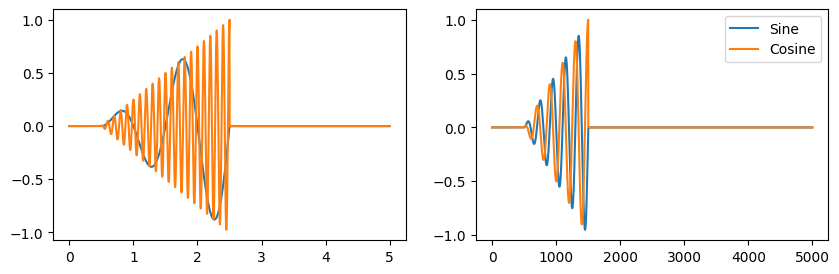

In [4]:
t = np.arange(5000)/1000
sin_wave = IncreasingSine(amp=1, freq=1, duration=2, delay=0.5)
cos_wave = IncreasingCosine(amp=1, freq=10, duration=2, delay=0.5)

fig, ax = plt.subplots( figsize=(10, 3), ncols=2)
ax[0].plot(t, sin_wave(t),label='Sine')
ax[0].plot(t, cos_wave(t),label='Cosine')
sin_wave = IncreasingSine(amp=1, freq=5, duration=1, delay=0.5)
cos_wave = IncreasingCosine(amp=1, freq=5, duration=1, delay=0.5)

ax[1].plot(sin_wave(t),label='Sine')
ax[1].plot(cos_wave(t),label='Cosine')

ax[1].legend()


## Single electrode example


In [5]:
# Time resolution
N.dt = 0.005*ms

axon_diameter = 27*um # um
# axon_nodes = 150 # number of axon nodes
# axon model, by default the central node is at origin of the coordinate system
axon_length = 120
stim_distance = -20
meas_distance = 30

Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm


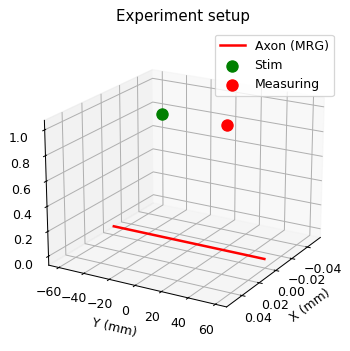

In [6]:
mrg = create_mrg(diameter=axon_diameter,
                 length=axon_length,
                 v_init=-80, 
                 #axonnodes=axon_nodes, 
                 verbose=True)

# extracellular current source
pointsource = IsotropicPoint(x=0, y = stim_distance * mm, z= 1 * mm, rhoe= 500*ohm*cm)
stim_amp = -1
stim_freq = 5
stim_duration = 2 
stim_delay = 0.25
stim = IncreasingSine(amp=stim_amp, 
                      freq=stim_freq,
                      duration=stim_duration,
                      delay=stim_delay)

electrode = pointsource << stim # Assignment

measuring_ps = IsotropicPoint(x=0, y = meas_distance * mm, z= 1 * mm, rhoe= 500*ohm*cm)
v_rec = StateMonitor(mrg.node, "v")

plot_setup_3d(mrg, [pointsource, measuring_ps], ['Stim','Measuring'],
              figsize=(4,4), title='Experiment setup',dpi=90)


In [7]:
# simulation environment
env = SimulationEnvironment(axons=[mrg], extra_stim=[electrode],
                            monitors=[v_rec])
env.run(runtime = 4 * ms,  progressbar=True, early_stopping=False)


3.5 ms: 100%|██████████| 800/800 [00:01<00:00, 554.83it/s]



Simulation Environment:
  # axons: 1
  # extracellular stimulating electrodes: 1
  dt: 0.005 ms

## Visualizing the nerve conduction overt time and space

In [8]:
mid_point = int(mrg.axonnodes/2)
distance_per_node = axon_length/mrg.axonnodes
displacement_nodes = int(meas_distance/distance_per_node)
print(mid_point, mrg.axonnodes, displacement_nodes)
meas_position = mid_point + displacement_nodes 
print(meas_position)

102 204 51
153


In [9]:
def calculate_delay(stim_time, v_rec, node, threshold=-20, abs_diff=False):
    """
    Calculate the delay of the AP at the measuring point
    """
    result = {
        'delay': np.inf,
        'num_aps': 0,
    }
    
    v = v_rec.v[node, :]
    t = v_rec.t

    as_bool = v > threshold
    pos_arrival = np.where(as_bool)[0]
    
    if len(pos_arrival)==0:
        return result
        
    changes =  np.diff(as_bool.astype(int))    
    pos_arrival = pos_arrival[0]

    result['num_aps'] = np.sum(changes==1)
    
    delay = v_rec.t[pos_arrival] - stim_time
    
    if abs_diff:
        delay = np.abs(delay)
        
    result['delay'] = delay
    
    return result

Text(0.5, 0, 'Time (ms)')

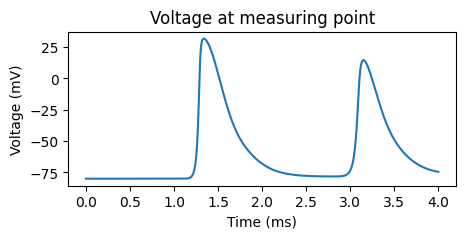

In [10]:
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(v_rec.t, v_rec.v[meas_position,:])
ax.set_title("Voltage at measuring point")
ax.set_ylabel("Voltage (mV)")
ax.set_xlabel("Time (ms)")

Delay: 1.03 ms
{'delay': 1.0349999999999837, 'num_aps': 2}


<Axes: title={'center': 'AP propagation'}, xlabel='Time (ms)', ylabel='Node Number'>

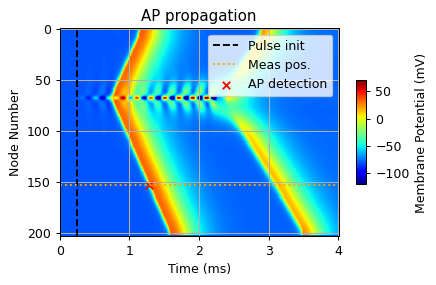

In [11]:
# An example of a failed blocking the AP progression to the right
res = calculate_delay(stim_delay, v_rec, meas_position)
print(f"Delay: {res['delay']:.2f} ms")
print(res)
plot_first_detection(mrg=mrg,
                     v_rec=v_rec,
                     stim_delay=stim_delay,
                     meas_position=meas_position,
                     propagation_delay=res['delay'],
                     figsize=(5,3),
                     dpi=90,
                     title="AP propagation")


## Performing Gaussian Process based Bayesian Optimization

In [12]:
def run_simulation(mrg: MRG, 
                   
                   stim_amp: float = -1.00, #* mA
                   stim_freq: float = 1.0, #kHz
                   stim_pw: float = 0.50, #* ms
                   stim_delay: float = 2.0, #* ms
                   
                   e_pos: float = 20.0, # mm
                   z_pos: float = 1.0, # mm
                   
                   sim_time: float = 5.0, # ms
                   verbose: bool = True) -> dict[str, APMonitor|StateMonitor]:
    """
    Run the AP blocking simulation with given stimulus parameters.
    
    Parameters:
    - stim_amp: Amplitude of the stimulus pulse (mA)
    - stim_pw: Pulse width of the simtulus pulse (ms)
    - stim_delay: Delay of the stimulus pulse (ms)
    
    General assumptions:
    - Electrodes are placed along the axon (y axis by default).
    - X placement is centered at 0 mm (origin).
    - Z placement is the same for both electrodes.
    
    - Medium is isotropic with a fixed resistivity of 500 ohm*cm.
    
    Returns:
    - ap_count: Number of action potentials reaching the end of the axon.
    """

    if verbose:
        print(f"Config: Amp. {stim_amp:.2f} mA Freq. {stim_freq:.2f} KHz,  PW {stim_pw:.2f} ms, Delay {stim_delay:.2f} ms")

    # Create stimuli
    stim = IncreasingSine(amp=stim_amp,
                          freq=stim_freq,
                          duration=stim_duration,
                          delay=stim_delay)

    # Create electrodes at both ends (set spacing of electrode_separation mm)
    pointsource_stim = IsotropicPoint(x=0 * mm, y=e_pos * mm, z=z_pos * mm, rhoe=500 * ohm * cm)

    # Assign stimuli to electrodes
    electrode_stim = pointsource_stim << stim
    
    monitors_dict = dict()
    v_rec = StateMonitor(mrg.node, "v")
    
    monitors_dict['v_rec'] = v_rec
    # Create the simulation environment
    env = SimulationEnvironment(
        axons = [mrg],
        extra_stim = [electrode_stim],
        monitors = [v_rec]
    )

    # Run the simulation for a sufficient duration to observe AP propagation
    env.run(sim_time * ms, early_stopping=False)
    
    return monitors_dict


def sinusoid_delay_objective(mrg,
                            meas_position,

                            stim_amp = [-1], 
                            stim_pw = [0.5],
                            stim_delay =[2],
                            stim_freq = [1],
                            abs_diff = False,
                            plot_results=False,

                            noise_level=0.0,
                            *args,
                            **kwargs
                            ):
    """
    Objective function to optimize AP blocking
    """  
              
    observations = []
    default_dict = {
        'ap_lines': [],
        'arrival_delay': np.nan
    }
    
    for s_amp, s_pw, s_delay, s_freq in zip(stim_amp, stim_pw, stim_delay, stim_freq):
        # Run the simulation with given parameters
        try:
            monitors_dict = run_simulation(mrg = mrg,
                                           stim_amp = s_amp,
                                           stim_pw = s_pw,
                                           stim_delay = s_delay,
                                           stim_freq = s_freq,
                                           *args,
                                           **kwargs)
            
            v_rec = monitors_dict['v_rec']            
            v_binary = v_rec.v > -0.20 # Assuming some threshold
            
            ap_lines = get_ap_directional(v_binary, 
                                          min_nodes_for_ap_start=1,
                                          y_propagation_threshold=5)
            
            results = calculate_delay(stim_time=s_delay, 
                                      v_rec=v_rec, 
                                      node=meas_position,
                                      abs_diff=abs_diff)
            if noise_level>0.0:
                results['delay_noised'] = results['delay'] + np.random.normal(0, noise_level)

            results['ap_lines'] = ap_lines
            
            if plot_results:
                plot_first_detection(mrg=mrg,
                                    v_rec=v_rec,
                                    stim_delay=s_delay,
                                    meas_position=meas_position,
                                    propagation_delay=results['delay'],
                                    figsize=(5,3),
                                    dpi=90,
                                    title="AP propagation")
                plt.show()
            print(results)
            
            observations.append(results)

        except Exception as e:
            print(f"Simulation failed with Amplitude {stim_amp:.2f} mA, Frequency {stim_freq:.2f} Hz,  Pulse Width {stim_pw:.2f} ms, Delay {stim_delay:.2f}")
            observations.append(default_dict)  

    return observations #np.array(observations).reshape(-1, 1)


In [13]:
# Define parameter bounds
# stim_amp = 0.5
# stim_freq = 5 # kHz
# stim_duration = 3 
# stim_delay = 0.5 Kept constant

lb = [0, 2.0, 0.2]  # Lower bounds for [block_amp, freq, pulse_width]
ub = [2, 10.0, 3]  # Upper bounds
col_names = ['Amplitude (mA)', 'Freq (kHz)', 'Pulse width (ms)']

STIM_DELAY = 0.5 # Delay initial pulse in ms
NOISE_LEVEL = 0.2/2 # Gaussian distributed noise in ms (90% of the time within 0.2 ms)

abs_diff = False
# Initialize scaler
scaler = CustomMinMaxScaler(feature_min=lb, 
                            feature_max=ub,
                            output_range=(-1, 1))

# Define search space
search_space = CustomBox(lower=[-1, -1, -1],
                         upper=[1, 1, 1])

# Generate initial amount of samples 
init_samples = 25
qp_minmax = search_space.sample_method(init_samples, skip=0).numpy()
qp_orig_scale = scaler.inverse_transform(qp_minmax)
stim_delay_vector = init_samples*[STIM_DELAY]

# Set desired diameter, length and v_init
axon_diameter = 27
axon_length = 120
stim_distance = -20
meas_distance = 30

mrg = create_mrg(diameter=axon_diameter,
                 length=axon_length, 
                 v_init=-80, 
                 verbose=True)

mid_point = int(mrg.axonnodes/2)
distance_per_node = axon_length/mrg.axonnodes
displacement_nodes = int(meas_distance / distance_per_node)
meas_position = mid_point + displacement_nodes 


Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm


Config: Amp. 1.00 mA Freq. 6.00 KHz,  PW 1.60 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 228.45it/s]


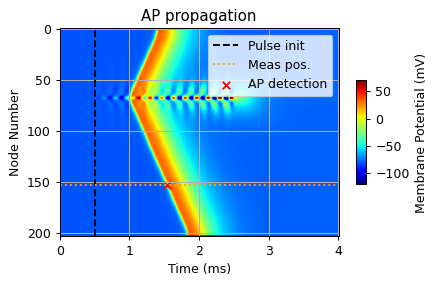

{'delay': 1.0399999999999783, 'num_aps': 1, 'delay_noised': 1.1125331087043215, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 205, 'component_end_time': 411, 'upward_line_coords': ((205, 65), (324, 1)), 'downward_line_coords': ((205, 70), (411, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 9, 'component_start_time': 252, 'component_end_time': 266, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 9, 'component_start_time': 288, 'component_end_time': 298, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 9, 'component_start_time': 322, 'component_end_time': 332, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 235.99it/s]


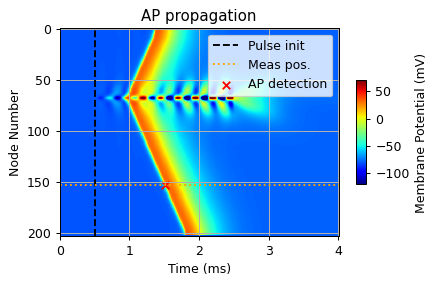

{'delay': 1.004999999999979, 'num_aps': 1, 'delay_noised': 1.0186319602758593, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 188, 'component_end_time': 403, 'upward_line_coords': ((188, 67), (317, 1)), 'downward_line_coords': ((188, 68), (403, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 280, 'component_end_time': 299, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 331, 'component_end_time': 350, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8, 'component_start_time': 380, 'component_end_time': 400, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 235.25it/s]


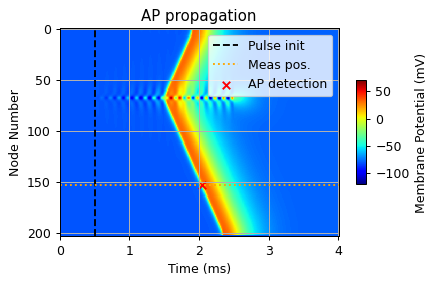

{'delay': 1.5399999999999676, 'num_aps': 1, 'delay_noised': 1.4677397349738632, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 305, 'component_end_time': 510, 'upward_line_coords': ((305, 64), (423, 1)), 'downward_line_coords': ((305, 70), (510, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 7, 'component_start_time': 366, 'component_end_time': 374, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 393, 'component_end_time': 397, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 418, 'component_end_time': 422, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 231.51it/s]


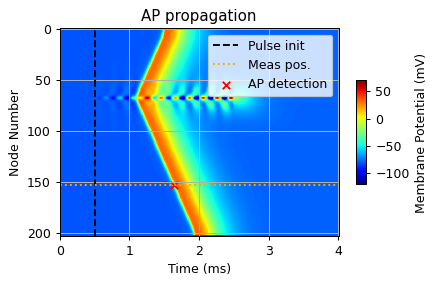

{'delay': 1.1399999999999761, 'num_aps': 1, 'delay_noised': 1.1978848830938809, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 223, 'component_end_time': 430, 'upward_line_coords': ((223, 66), (343, 1)), 'downward_line_coords': ((223, 68), (430, 202)), 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 7, 'component_start_time': 284, 'component_end_time': 298, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 7, 'component_start_time': 327, 'component_end_time': 337, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 7, 'total_of_features': 7, 'component_start_time': 367, 'component_end_time': 378, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 235.88it/s]


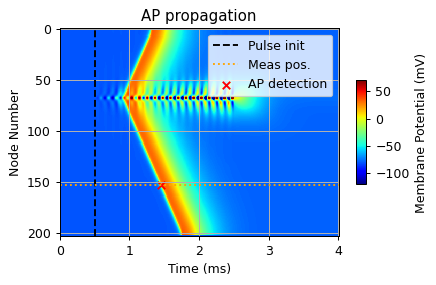

{'delay': 0.9499999999999802, 'num_aps': 1, 'delay_noised': 0.9630212727551739, 'ap_lines': [{'label': 1, 'total_of_features': 23, 'component_start_time': 182, 'component_end_time': 392, 'upward_line_coords': ((182, 67), (305, 1)), 'downward_line_coords': ((182, 67), (392, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 7, 'total_of_features': 23, 'component_start_time': 247, 'component_end_time': 255, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 23, 'component_start_time': 270, 'component_end_time': 277, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 9, 'total_of_features': 23, 'component_start_time': 292, 'component_end_time': 300, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 261.91it/s]


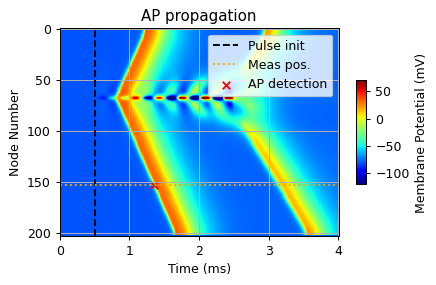

{'delay': 0.8549999999999822, 'num_aps': 2, 'delay_noised': 0.9510428757252286, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 163, 'component_end_time': 373, 'upward_line_coords': ((163, 67), (286, 1)), 'downward_line_coords': ((163, 68), (373, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 275, 'component_end_time': 297, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 341, 'component_end_time': 366, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 7, 'component_start_time': 406, 'component_end_time': 433, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 230.39it/s]


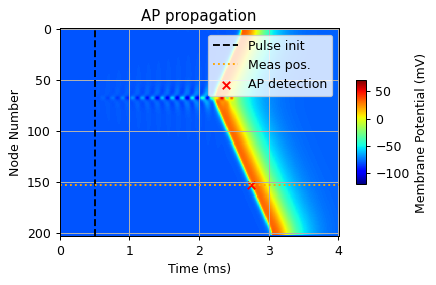

{'delay': 2.2499999999999525, 'num_aps': 1, 'delay_noised': 2.3446421266705926, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 446, 'component_end_time': 652, 'upward_line_coords': ((446, 66), (565, 1)), 'downward_line_coords': ((446, 69), (652, 202)), 'y_span_at_start': 2, 'min_y_at_start': 66, 'max_y_at_start': 69}]}
Config: Amp. 0.38 mA Freq. 4.50 KHz,  PW 2.83 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 265.44it/s]


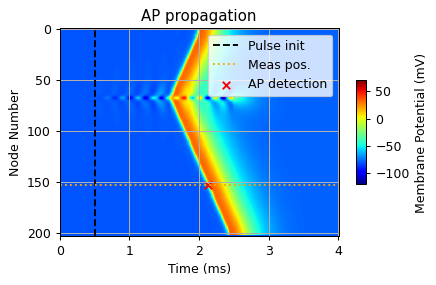

{'delay': 1.6299999999999657, 'num_aps': 1, 'delay_noised': 1.539962385079569, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 318, 'component_end_time': 529, 'upward_line_coords': ((318, 67), (442, 1)), 'downward_line_coords': ((318, 67), (529, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 4, 'component_start_time': 397, 'component_end_time': 406, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 4, 'component_start_time': 445, 'component_end_time': 449, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 488, 'component_end_time': 496, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 243.73it/s]


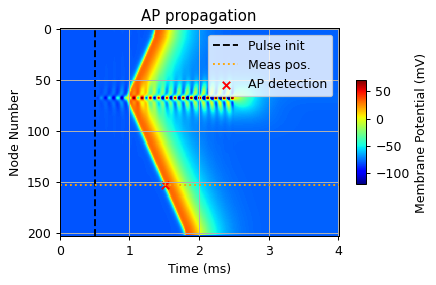

{'delay': 1.004999999999979, 'num_aps': 1, 'delay_noised': 1.1192830581260367, 'ap_lines': [{'label': 1, 'total_of_features': 16, 'component_start_time': 198, 'component_end_time': 403, 'upward_line_coords': ((198, 65), (317, 1)), 'downward_line_coords': ((198, 70), (403, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 4, 'total_of_features': 16, 'component_start_time': 255, 'component_end_time': 264, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 16, 'component_start_time': 280, 'component_end_time': 288, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 16, 'component_start_time': 304, 'component_end_time': 311, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 257.72it/s]


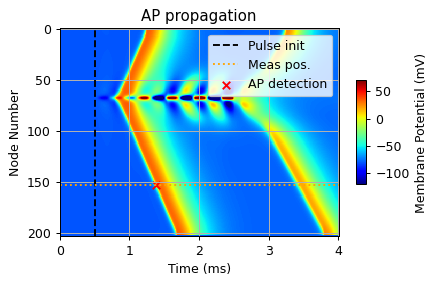

{'delay': 0.8749999999999818, 'num_aps': 2, 'delay_noised': 0.7674613337132532, 'ap_lines': [{'label': 1, 'total_of_features': 13, 'component_start_time': 160, 'component_end_time': 378, 'upward_line_coords': ((160, 67), (291, 1)), 'downward_line_coords': ((160, 68), (378, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 13, 'component_start_time': 224, 'component_end_time': 258, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 13, 'component_start_time': 308, 'component_end_time': 340, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 13, 'component_start_time': 356, 'component_end_time': 371, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 61, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 237.36it/s]


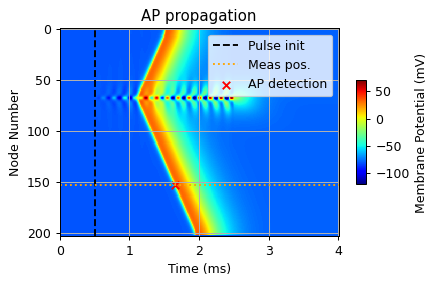

{'delay': 1.149999999999976, 'num_aps': 1, 'delay_noised': 0.9651744578371578, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 225, 'component_end_time': 432, 'upward_line_coords': ((225, 67), (345, 1)), 'downward_line_coords': ((225, 68), (432, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 9, 'component_start_time': 271, 'component_end_time': 284, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 9, 'component_start_time': 304, 'component_end_time': 314, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 9, 'total_of_features': 9, 'component_start_time': 336, 'component_end_time': 345, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 232.63it/s]


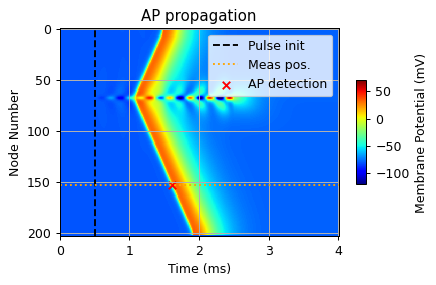

{'delay': 1.1099999999999768, 'num_aps': 1, 'delay_noised': 1.0912629215389622, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 217, 'component_end_time': 425, 'upward_line_coords': ((217, 67), (338, 1)), 'downward_line_coords': ((217, 68), (425, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 5, 'component_start_time': 311, 'component_end_time': 322, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 5, 'component_start_time': 368, 'component_end_time': 383, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 5, 'component_start_time': 422, 'component_end_time': 441, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 223.25it/s]


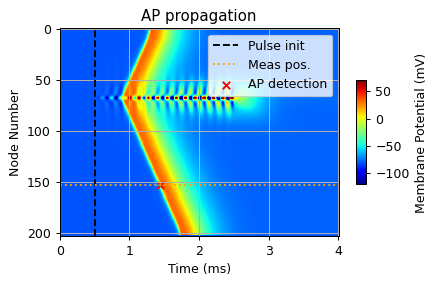

{'delay': 0.9349999999999805, 'num_aps': 1, 'delay_noised': 0.9188782429698941, 'ap_lines': [{'label': 1, 'total_of_features': 17, 'component_start_time': 183, 'component_end_time': 389, 'upward_line_coords': ((183, 66), (302, 1)), 'downward_line_coords': ((183, 69), (389, 202)), 'y_span_at_start': 2, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 5, 'total_of_features': 17, 'component_start_time': 250, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 17, 'component_start_time': 277, 'component_end_time': 286, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 17, 'component_start_time': 304, 'component_end_time': 313, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 236.03it/s]


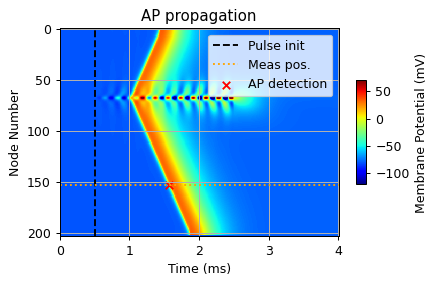

{'delay': 1.0649999999999777, 'num_aps': 1, 'delay_noised': 1.0480978942339516, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 203, 'component_end_time': 416, 'upward_line_coords': ((203, 67), (329, 1)), 'downward_line_coords': ((203, 67), (416, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 8, 'component_start_time': 267, 'component_end_time': 281, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 305, 'component_end_time': 317, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 342, 'component_end_time': 354, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 239.88it/s]


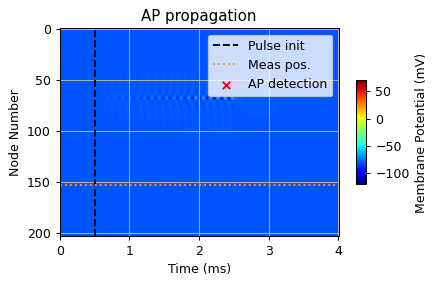

{'delay': inf, 'num_aps': 0, 'delay_noised': inf, 'ap_lines': []}
Config: Amp. 0.19 mA Freq. 5.75 KHz,  PW 1.51 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 220.69it/s]


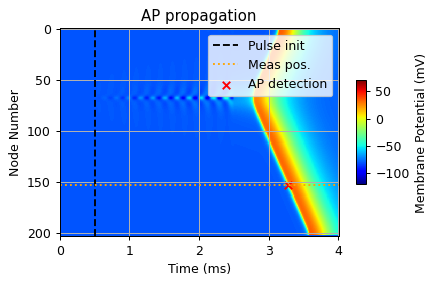

{'delay': 2.7749999999999413, 'num_aps': 1, 'delay_noised': 2.619354152427821, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 556, 'component_end_time': 758, 'upward_line_coords': ((556, 65), (671, 1)), 'downward_line_coords': ((556, 69), (758, 202)), 'y_span_at_start': 5, 'min_y_at_start': 65, 'max_y_at_start': 69}]}
Config: Amp. 1.19 mA Freq. 9.75 KHz,  PW 2.91 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 243.03it/s]


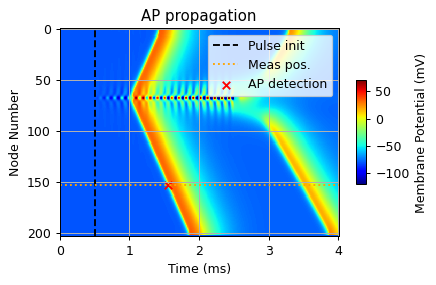

{'delay': 1.0599999999999778, 'num_aps': 2, 'delay_noised': 1.2503726653054015, 'ap_lines': [{'label': 1, 'total_of_features': 15, 'component_start_time': 209, 'component_end_time': 414, 'upward_line_coords': ((209, 64), (327, 1)), 'downward_line_coords': ((209, 71), (414, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 3, 'total_of_features': 15, 'component_start_time': 256, 'component_end_time': 264, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 4, 'total_of_features': 15, 'component_start_time': 277, 'component_end_time': 284, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 15, 'component_start_time': 298, 'component_end_time': 304, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 229.66it/s]


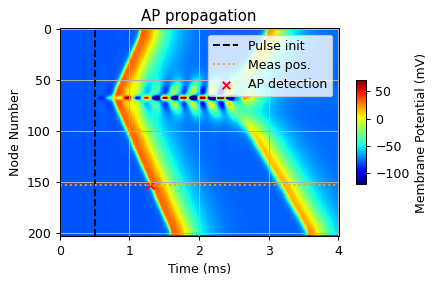

{'delay': 0.7999999999999834, 'num_aps': 2, 'delay_noised': 0.722394495715461, 'ap_lines': [{'label': 1, 'total_of_features': 13, 'component_start_time': 154, 'component_end_time': 362, 'upward_line_coords': ((154, 67), (276, 1)), 'downward_line_coords': ((154, 68), (362, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 13, 'component_start_time': 239, 'component_end_time': 258, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 13, 'component_start_time': 293, 'component_end_time': 313, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 13, 'component_start_time': 345, 'component_end_time': 367, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 235.94it/s]


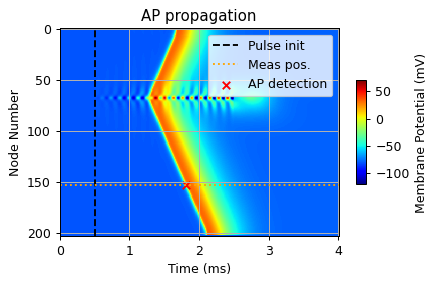

{'delay': 1.3099999999999725, 'num_aps': 1, 'delay_noised': 1.1205785111317748, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 259, 'component_end_time': 464, 'upward_line_coords': ((259, 65), (377, 1)), 'downward_line_coords': ((259, 70), (464, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 8, 'component_start_time': 323, 'component_end_time': 331, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8, 'component_start_time': 350, 'component_end_time': 356, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 8, 'component_start_time': 376, 'component_end_time': 382, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 242.56it/s]


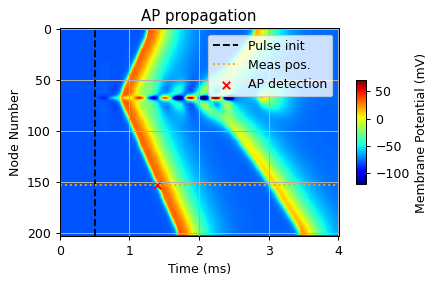

{'delay': 0.8999999999999813, 'num_aps': 2, 'delay_noised': 0.9472027619305705, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 175, 'component_end_time': 382, 'upward_line_coords': ((175, 66), (295, 1)), 'downward_line_coords': ((175, 69), (382, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 7, 'component_start_time': 292, 'component_end_time': 314, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 7, 'component_start_time': 364, 'component_end_time': 390, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 7, 'component_start_time': 434, 'component_end_time': 463, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 245.95it/s]


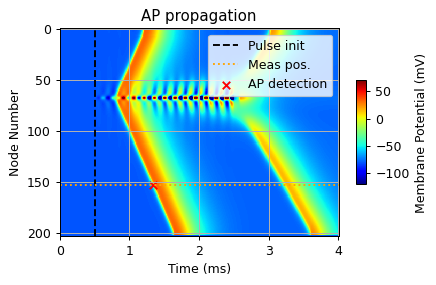

{'delay': 0.8399999999999825, 'num_aps': 2, 'delay_noised': 0.8256863993845156, 'ap_lines': [{'label': 1, 'total_of_features': 23, 'component_start_time': 165, 'component_end_time': 370, 'upward_line_coords': ((165, 65), (283, 1)), 'downward_line_coords': ((165, 70), (370, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 9, 'total_of_features': 23, 'component_start_time': 237, 'component_end_time': 248, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 10, 'total_of_features': 23, 'component_start_time': 267, 'component_end_time': 278, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 11, 'total_of_features': 23, 'component_start_time': 296, 'component_end_time': 307, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start'

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 242.67it/s]


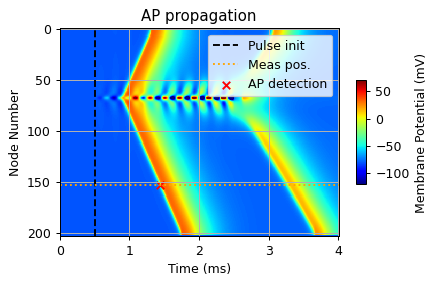

{'delay': 0.9449999999999803, 'num_aps': 2, 'delay_noised': 0.9473070084385232, 'ap_lines': [{'label': 1, 'total_of_features': 12, 'component_start_time': 178, 'component_end_time': 391, 'upward_line_coords': ((178, 67), (304, 1)), 'downward_line_coords': ((178, 67), (391, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 12, 'component_start_time': 251, 'component_end_time': 267, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 12, 'component_start_time': 295, 'component_end_time': 310, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 12, 'component_start_time': 336, 'component_end_time': 352, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 231.95it/s]


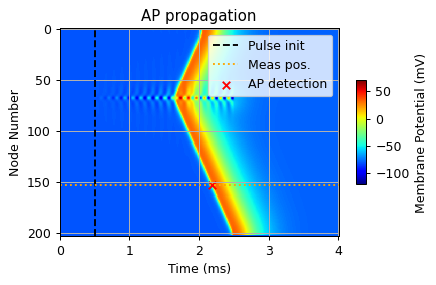

{'delay': 1.6799999999999646, 'num_aps': 1, 'delay_noised': 1.7152929497688476, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 333, 'component_end_time': 538, 'upward_line_coords': ((333, 65), (452, 1)), 'downward_line_coords': ((333, 70), (538, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 6, 'component_start_time': 388, 'component_end_time': 396, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 6, 'component_start_time': 413, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 437, 'component_end_time': 440, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 236.92it/s]


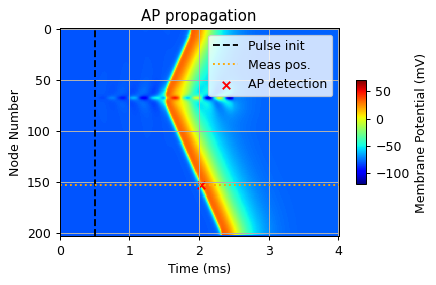

{'delay': 1.519999999999968, 'num_aps': 1, 'delay_noised': 1.5749676595593578, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 305, 'component_end_time': 507, 'upward_line_coords': ((305, 62), (420, 1)), 'downward_line_coords': ((305, 72), (507, 202)), 'y_span_at_start': 8, 'min_y_at_start': 62, 'max_y_at_start': 72}]}
Config: Amp. 1.31 mA Freq. 7.25 KHz,  PW 0.29 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 233.06it/s]


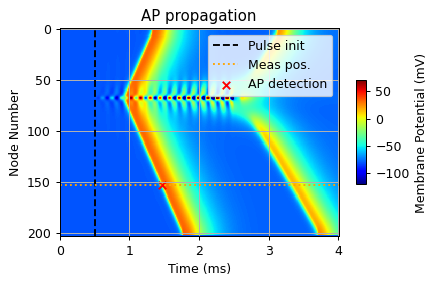

{'delay': 0.95999999999998, 'num_aps': 2, 'delay_noised': 1.0243498311024433, 'ap_lines': [{'label': 1, 'total_of_features': 15, 'component_start_time': 190, 'component_end_time': 395, 'upward_line_coords': ((190, 64), (308, 1)), 'downward_line_coords': ((190, 70), (395, 202)), 'y_span_at_start': 4, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 4, 'total_of_features': 15, 'component_start_time': 255, 'component_end_time': 265, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 15, 'component_start_time': 283, 'component_end_time': 292, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 6, 'total_of_features': 15, 'component_start_time': 311, 'component_end_time': 320, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68

In [14]:
# Compute observations of for the initial amount of samples
observations = sinusoid_delay_objective(mrg,
                                       
                                       stim_amp=qp_orig_scale[:, 0],
                                       stim_freq=qp_orig_scale[:, 1],
                                       stim_pw=qp_orig_scale[:, 2],
                                       
                                       stim_delay=stim_delay_vector,
                                       meas_position = meas_position, 
                                       e_pos=stim_distance,
                                       abs_diff=False,
                                       sim_time=4,
                                       plot_results=True,
                                       noise_level=NOISE_LEVEL)

## Visualizing initial samples

In [15]:
if NOISE_LEVEL>0:
    obs_label = np.array([o['delay_noised'] for o in observations]).reshape(-1,1)
else:
    obs_label = np.array([o['delay'] for o in observations]).reshape(-1,1)
real_label = np.array([o['delay'] for o in observations]).reshape(-1,1)


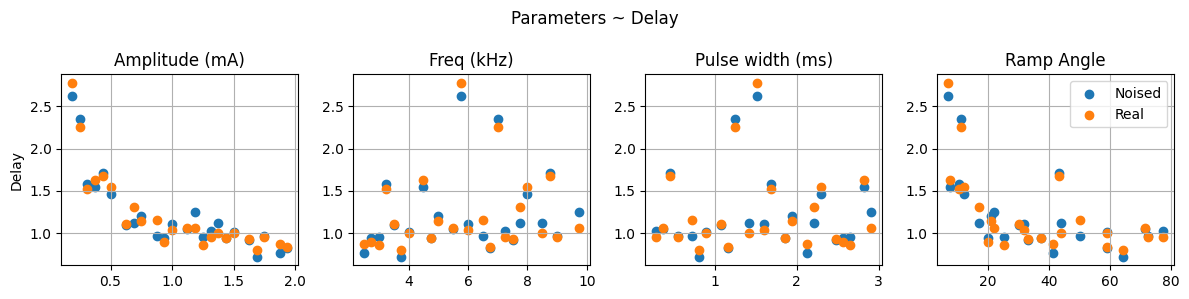

In [16]:

fig, ax = plt.subplots(ncols=4,figsize=(12,3))
ax[0].scatter(qp_orig_scale[:,0], obs_label)
ax[1].scatter(qp_orig_scale[:,1], obs_label)
ax[2].scatter(qp_orig_scale[:,2], obs_label)
ax[3].scatter(np.degrees(np.arctan(qp_orig_scale[:,0]/qp_orig_scale[:,2])), obs_label, label='Noised')

if NOISE_LEVEL>0:
    ax[0].scatter(qp_orig_scale[:,0], real_label)
    ax[1].scatter(qp_orig_scale[:,1], real_label)
    ax[2].scatter(qp_orig_scale[:,2], real_label)
    ax[3].scatter(np.degrees(np.arctan(qp_orig_scale[:,0]/qp_orig_scale[:,2])), real_label, label='Real')


ax[0].set_ylabel("Delay")
for e, col in enumerate(col_names):
    ax[e].set_title(col)
    ax[e].grid()

ax[3].set_title("Ramp Angle")
ax[3].legend()
ax[3].grid()
fig.suptitle("Parameters ~ Delay")
fig.tight_layout()

## Meta-models


Here we will approach the model in three different ways:
- As a learning approach focused on reducing Global Uncertainty by means of PredictiveVariance (eventually could be done with IntegratedVarianceReduction).
- As an online optimization problem focused on finding better minimums. In this case, we will defined a target desired delay and model it as an absolute loss so that negative and positive delays are counted the same. We can use ExpectedImprovement or AugmentedExpectedImprovement (a more exploration driven variation)
- As a Constrained optimization in which we use ExpectedImprovement and ProbabilityofFeasibility with the intention of targeting a certain delay while avoiding triggering 2 APs.

### Variance Reduction
This model focuses in reducing global variance (exploration) using PredictiveVariance

In [17]:
# If Noise is higher than 0 we assume we are dealing with noisy simulations and select the noised injected sample
if NOISE_LEVEL>0:
    obs_label = np.array([o['delay_noised'] for o in observations]).reshape(-1,1)
else:
    obs_label = np.array([o['delay'] for o in observations]).reshape(-1,1)
real_label = np.array([o['delay'] for o in observations]).reshape(-1,1)
# We replace np.inf values with a fixed and relatively large value 
#  (outside of the simulation range)
    
obs_label[obs_label == np.inf] = 6
init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(obs_label, tf.float64))


In [18]:
# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp_orig_scale)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp_orig_scale))

In [19]:
# Build model
model_config = {
    'classification': False,
    'variational': False,
    'sparse': False,
    'trainable_likelihood': True,
    'likelihood_variance':1e-5,
    'kernel_variance': None,
}

online_model = online_learning.build_model(init_dataset, 
                                           search_space,
                                           model_config)

# Set up acquisition function and rule
acq = PredictiveVariance()
rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   #overwrite=True,
                                   #track_path='nerve_block'
                                   )

In [20]:
# Optimization loop as for a next point to query
max_iters = 50  # Increase the number of iterations as needed
iter = 0

while iter <= max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')
    
    next_point = ask_tell.ask()
    
    if next_point is not None:
        qp_minmax_new = next_point.numpy()
    else:
        raise ValueError("ask_tell returned None - check optimizer setup")
    
    qp_new = scaler.inverse_transform(qp_minmax_new)
    if qp_new.ndim==1:
        qp_new = qp_new.reshape(-1, 1)
    stim_delays = len(qp_new)*[STIM_DELAY]

    # Run the simulation and get observations
    observations_new = sinusoid_delay_objective(mrg,
                                            stim_amp = qp_new[:, 0],
                                            stim_freq = qp_new[:, 1],
                                            stim_pw = qp_new[:, 2],
                                            stim_delay = stim_delays,
                                            meas_position = meas_position, 
                                            e_pos = stim_distance,
                                            abs_diff = False,
                                            sim_time = 4,
                                            plot_results = False,
                                            noise_level=NOISE_LEVEL)
            
    #obs_label = [o['stim_blocked'] for o in observations_new]
    if NOISE_LEVEL>0:
        obs_label = np.array([o['delay_noised'] for o in observations_new]).reshape(-1,1)
    else:
        obs_label = np.array([o['delay'] for o in observations_new]).reshape(-1,1)
        
    obs_label[obs_label == np.inf] = 6

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))
    
    # Create the new dataset
    tagged_output = Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(obs_label, tf.float64))
    
    # Update the optimizer with new data
    ask_tell.tell(tagged_output)
    iter += 1

# Save results
#ask_tell.save()

Config: Amp. 0.00 mA Freq. 2.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 231.65it/s]


{'delay': inf, 'num_aps': 0, 'delay_noised': inf, 'ap_lines': []}
Config: Amp. 2.00 mA Freq. 10.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 230.16it/s]


{'delay': 0.9249999999999807, 'num_aps': 1, 'delay_noised': 0.8873542609936089, 'ap_lines': [{'label': 1, 'total_of_features': 31, 'component_start_time': 176, 'component_end_time': 387, 'upward_line_coords': ((176, 67), (300, 1)), 'downward_line_coords': ((176, 68), (387, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 10, 'total_of_features': 31, 'component_start_time': 232, 'component_end_time': 240, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 31, 'component_start_time': 244, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 61, 'max_y_at_start': 62}, {'label': 31, 'total_of_features': 31, 'component_start_time': 244, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 72, 'max_y_at_start'

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 241.12it/s]


{'delay': 0.9399999999999804, 'num_aps': 2, 'delay_noised': 1.2133601764226307, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 169, 'component_end_time': 390, 'upward_line_coords': ((169, 67), (303, 1)), 'downward_line_coords': ((169, 68), (390, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 10, 'component_start_time': 256, 'component_end_time': 298, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 6, 'total_of_features': 10, 'component_start_time': 358, 'component_end_time': 400, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 10, 'component_start_time': 412, 'component_end_time': 445, 'upward_line_coords': ((412, 62), (442, 52)), 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 62, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 239.05it/s]


{'delay': inf, 'num_aps': 0, 'delay_noised': inf, 'ap_lines': []}
Config: Amp. 0.92 mA Freq. 10.00 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 253.52it/s]


{'delay': 1.1999999999999749, 'num_aps': 1, 'delay_noised': 1.3380313418279945, 'ap_lines': [{'label': 1, 'total_of_features': 12, 'component_start_time': 234, 'component_end_time': 442, 'upward_line_coords': ((234, 67), (355, 1)), 'downward_line_coords': ((234, 68), (442, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 12, 'component_start_time': 292, 'component_end_time': 300, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 12, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 11, 'total_of_features': 12, 'component_start_time': 334, 'component_end_time': 339, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start':

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 234.14it/s]


{'delay': inf, 'num_aps': 0, 'delay_noised': inf, 'ap_lines': []}
Config: Amp. 1.56 mA Freq. 2.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.63it/s]


{'delay': 0.9399999999999804, 'num_aps': 2, 'delay_noised': 1.049083523919103, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 172, 'component_end_time': 390, 'upward_line_coords': ((172, 67), (304, 1)), 'downward_line_coords': ((172, 68), (390, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 257, 'component_end_time': 296, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 8, 'component_start_time': 359, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 417, 'component_end_time': 441, 'upward_line_coords': ((417, 60), (439, 54)), 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 60, 'max_

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 233.38it/s]


{'delay': inf, 'num_aps': 0, 'delay_noised': inf, 'ap_lines': []}
Config: Amp. 2.00 mA Freq. 10.00 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 235.38it/s]


{'delay': 0.9249999999999807, 'num_aps': 1, 'delay_noised': 1.088053919731037, 'ap_lines': [{'label': 1, 'total_of_features': 31, 'component_start_time': 176, 'component_end_time': 387, 'upward_line_coords': ((176, 67), (300, 1)), 'downward_line_coords': ((176, 68), (387, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 10, 'total_of_features': 31, 'component_start_time': 232, 'component_end_time': 240, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 31, 'component_start_time': 244, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 61, 'max_y_at_start': 62}, {'label': 31, 'total_of_features': 31, 'component_start_time': 244, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 72, 'max_y_at_start':

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 247.38it/s]


{'delay': 1.0149999999999788, 'num_aps': 2, 'delay_noised': 0.7880117042781712, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 196, 'component_end_time': 405, 'upward_line_coords': ((196, 67), (318, 1)), 'downward_line_coords': ((196, 68), (405, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 6, 'component_start_time': 260, 'component_end_time': 287, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 6, 'component_start_time': 365, 'component_end_time': 394, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 459, 'component_end_time': 496, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 197.46it/s]


{'delay': 1.42499999999997, 'num_aps': 1, 'delay_noised': 1.5453737464933512, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 277, 'component_end_time': 487, 'upward_line_coords': ((277, 67), (400, 1)), 'downward_line_coords': ((277, 67), (487, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 10, 'component_start_time': 332, 'component_end_time': 340, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 10, 'component_start_time': 353, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 6, 'total_of_features': 10, 'component_start_time': 374, 'component_end_time': 378, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 237.74it/s]


{'delay': 0.9499999999999802, 'num_aps': 2, 'delay_noised': 0.8692645247393874, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 177, 'component_end_time': 393, 'upward_line_coords': ((177, 67), (306, 1)), 'downward_line_coords': ((177, 68), (393, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 259, 'component_end_time': 294, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 360, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 6, 'component_start_time': 457, 'component_end_time': 499, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 236.99it/s]


{'delay': 0.9499999999999802, 'num_aps': 1, 'delay_noised': 1.021084258291303, 'ap_lines': [{'label': 1, 'total_of_features': 23, 'component_start_time': 188, 'component_end_time': 393, 'upward_line_coords': ((188, 64), (306, 1)), 'downward_line_coords': ((188, 71), (393, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 6, 'total_of_features': 23, 'component_start_time': 231, 'component_end_time': 241, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 23, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 8, 'total_of_features': 23, 'component_start_time': 273, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 225.99it/s]


{'delay': 0.9749999999999797, 'num_aps': 2, 'delay_noised': 0.9212208265700057, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 184, 'component_end_time': 397, 'upward_line_coords': ((184, 67), (310, 1)), 'downward_line_coords': ((184, 68), (397, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 6, 'component_start_time': 261, 'component_end_time': 290, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 6, 'component_start_time': 363, 'component_end_time': 397, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 458, 'component_end_time': 498, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 233.57it/s]


{'delay': 0.7749999999999839, 'num_aps': 2, 'delay_noised': 0.9122943280668934, 'ap_lines': [{'label': 1, 'total_of_features': 16, 'component_start_time': 151, 'component_end_time': 358, 'upward_line_coords': ((151, 66), (270, 1)), 'downward_line_coords': ((151, 68), (358, 202)), 'y_span_at_start': 2, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 16, 'component_start_time': 222, 'component_end_time': 240, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 16, 'component_start_time': 270, 'component_end_time': 288, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 9, 'total_of_features': 16, 'component_start_time': 316, 'component_end_time': 335, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 237.49it/s]


{'delay': 1.9999999999999578, 'num_aps': 1, 'delay_noised': 2.0531025707486155, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 394, 'component_end_time': 602, 'upward_line_coords': ((394, 67), (515, 1)), 'downward_line_coords': ((394, 68), (602, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 453, 'component_end_time': 459, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 4, 'component_start_time': 474, 'component_end_time': 478, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 496, 'component_end_time': 497, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 241.62it/s]


{'delay': 1.4449999999999696, 'num_aps': 1, 'delay_noised': 1.3621454061616993, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 276, 'component_end_time': 492, 'upward_line_coords': ((276, 67), (405, 1)), 'downward_line_coords': ((276, 68), (492, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 3, 'component_start_time': 365, 'component_end_time': 387, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 3, 'component_start_time': 465, 'component_end_time': 496, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 1.37 mA Freq. 2.00 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 234.35it/s]


{'delay': 0.9449999999999803, 'num_aps': 2, 'delay_noised': 0.885829320230723, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 173, 'component_end_time': 391, 'upward_line_coords': ((173, 67), (304, 1)), 'downward_line_coords': ((173, 67), (391, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 258, 'component_end_time': 296, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8, 'component_start_time': 359, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 420, 'component_end_time': 438, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 60, 'max_y_at_start': 61}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 238.49it/s]


{'delay': 1.2549999999999737, 'num_aps': 1, 'delay_noised': 1.069628762074431, 'ap_lines': [{'label': 1, 'total_of_features': 11, 'component_start_time': 249, 'component_end_time': 453, 'upward_line_coords': ((249, 63), (366, 1)), 'downward_line_coords': ((249, 71), (453, 202)), 'y_span_at_start': 8, 'min_y_at_start': 63, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 11, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 11, 'component_start_time': 334, 'component_end_time': 339, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 9, 'total_of_features': 11, 'component_start_time': 354, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 234.51it/s]


{'delay': 2.039999999999957, 'num_aps': 1, 'delay_noised': 2.126683369379964, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 403, 'component_end_time': 611, 'upward_line_coords': ((403, 67), (524, 1)), 'downward_line_coords': ((403, 68), (611, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 1.85 mA Freq. 10.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 230.61it/s]


{'delay': 0.9349999999999805, 'num_aps': 1, 'delay_noised': 0.9140432211566518, 'ap_lines': [{'label': 23, 'total_of_features': 30, 'component_start_time': 178, 'component_end_time': 180, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 1, 'total_of_features': 30, 'component_start_time': 183, 'component_end_time': 389, 'upward_line_coords': ((183, 66), (302, 1)), 'downward_line_coords': ((183, 69), (389, 202)), 'y_span_at_start': 2, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 9, 'total_of_features': 30, 'component_start_time': 232, 'component_end_time': 240, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 30, 'component_start_time': 244, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 60, 'max_y_at_start':

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 234.35it/s]


{'delay': 1.1349999999999763, 'num_aps': 1, 'delay_noised': 1.2087319247672348, 'ap_lines': [{'label': 1, 'total_of_features': 13, 'component_start_time': 223, 'component_end_time': 429, 'upward_line_coords': ((223, 66), (342, 1)), 'downward_line_coords': ((223, 69), (429, 202)), 'y_span_at_start': 2, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 13, 'component_start_time': 272, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 13, 'component_start_time': 293, 'component_end_time': 299, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 13, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 239.56it/s]


{'delay': 1.0149999999999788, 'num_aps': 1, 'delay_noised': 1.1061688236833616, 'ap_lines': [{'label': 1, 'total_of_features': 20, 'component_start_time': 195, 'component_end_time': 405, 'upward_line_coords': ((195, 67), (318, 1)), 'downward_line_coords': ((195, 68), (405, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 20, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 20, 'component_start_time': 273, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 20, 'component_start_time': 293, 'component_end_time': 300, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 235.53it/s]


{'delay': 0.9399999999999804, 'num_aps': 2, 'delay_noised': 1.1041869857548392, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 170, 'component_end_time': 390, 'upward_line_coords': ((170, 67), (303, 1)), 'downward_line_coords': ((170, 68), (390, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 10, 'component_start_time': 257, 'component_end_time': 297, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 10, 'component_start_time': 358, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 10, 'component_start_time': 414, 'component_end_time': 443, 'upward_line_coords': ((414, 61), (441, 53)), 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 61, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 242.62it/s]


{'delay': 0.9849999999999794, 'num_aps': 2, 'delay_noised': 1.0883909661644657, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 188, 'component_end_time': 400, 'upward_line_coords': ((188, 67), (313, 1)), 'downward_line_coords': ((188, 68), (400, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 6, 'component_start_time': 261, 'component_end_time': 288, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 6, 'component_start_time': 364, 'component_end_time': 396, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 458, 'component_end_time': 497, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 216.48it/s]


{'delay': inf, 'num_aps': 0, 'delay_noised': inf, 'ap_lines': []}
Config: Amp. 0.56 mA Freq. 10.00 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 223.81it/s]


{'delay': 1.5149999999999681, 'num_aps': 1, 'delay_noised': 1.5423475659808294, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 296, 'component_end_time': 506, 'upward_line_coords': ((296, 67), (419, 1)), 'downward_line_coords': ((296, 67), (506, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 9, 'component_start_time': 352, 'component_end_time': 360, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 9, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 9, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 230.70it/s]


{'delay': 0.9549999999999801, 'num_aps': 2, 'delay_noised': 1.029997683156603, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 178, 'component_end_time': 393, 'upward_line_coords': ((178, 67), (306, 1)), 'downward_line_coords': ((178, 68), (393, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 259, 'component_end_time': 293, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 361, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 6, 'component_start_time': 457, 'component_end_time': 498, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 229.60it/s]


{'delay': 0.9399999999999804, 'num_aps': 1, 'delay_noised': 0.9662754807933528, 'ap_lines': [{'label': 1, 'total_of_features': 25, 'component_start_time': 185, 'component_end_time': 390, 'upward_line_coords': ((185, 65), (304, 1)), 'downward_line_coords': ((185, 70), (390, 202)), 'y_span_at_start': 3, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 7, 'total_of_features': 25, 'component_start_time': 232, 'component_end_time': 240, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 8, 'total_of_features': 25, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 9, 'total_of_features': 25, 'component_start_time': 273, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 242.24it/s]


{'delay': 1.0399999999999783, 'num_aps': 1, 'delay_noised': 1.189895115299125, 'ap_lines': [{'label': 1, 'total_of_features': 18, 'component_start_time': 205, 'component_end_time': 410, 'upward_line_coords': ((205, 64), (323, 1)), 'downward_line_coords': ((205, 70), (410, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 4, 'total_of_features': 18, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 18, 'component_start_time': 264, 'component_end_time': 266, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 62, 'max_y_at_start': 62}, {'label': 18, 'total_of_features': 18, 'component_start_time': 264, 'component_end_time': 266, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 73, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 232.47it/s]


{'delay': 1.5449999999999675, 'num_aps': 1, 'delay_noised': 1.4560934008019828, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 304, 'component_end_time': 511, 'upward_line_coords': ((304, 66), (424, 1)), 'downward_line_coords': ((304, 69), (511, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 2, 'component_start_time': 359, 'component_end_time': 376, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.84 mA Freq. 2.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 251.00it/s]


{'delay': 0.9699999999999798, 'num_aps': 2, 'delay_noised': 1.073445850089786, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 182, 'component_end_time': 396, 'upward_line_coords': ((182, 67), (309, 1)), 'downward_line_coords': ((182, 67), (396, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 6, 'component_start_time': 261, 'component_end_time': 291, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 362, 'component_end_time': 397, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 6, 'component_start_time': 458, 'component_end_time': 498, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 234.68it/s]


{'delay': 0.9499999999999802, 'num_aps': 2, 'delay_noised': 0.8669234180012247, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 176, 'component_end_time': 392, 'upward_line_coords': ((176, 67), (305, 1)), 'downward_line_coords': ((176, 68), (392, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 259, 'component_end_time': 294, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 7, 'component_start_time': 360, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 429, 'component_end_time': 430, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 59, 'max_y_at_start': 59},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 241.18it/s]


{'delay': 0.9449999999999803, 'num_aps': 1, 'delay_noised': 0.9993839899495129, 'ap_lines': [{'label': 1, 'total_of_features': 25, 'component_start_time': 186, 'component_end_time': 391, 'upward_line_coords': ((186, 65), (305, 1)), 'downward_line_coords': ((186, 70), (391, 202)), 'y_span_at_start': 2, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 7, 'total_of_features': 25, 'component_start_time': 232, 'component_end_time': 240, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 8, 'total_of_features': 25, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 9, 'total_of_features': 25, 'component_start_time': 273, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 232.13it/s]


{'delay': 1.329999999999972, 'num_aps': 1, 'delay_noised': 1.2781765319551932, 'ap_lines': [{'label': 1, 'total_of_features': 11, 'component_start_time': 258, 'component_end_time': 468, 'upward_line_coords': ((258, 67), (381, 1)), 'downward_line_coords': ((258, 67), (468, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 11, 'component_start_time': 312, 'component_end_time': 320, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 11, 'component_start_time': 333, 'component_end_time': 339, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 11, 'component_start_time': 354, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 243.41it/s]


{'delay': 0.9449999999999803, 'num_aps': 2, 'delay_noised': 0.771844138091974, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 174, 'component_end_time': 391, 'upward_line_coords': ((174, 67), (304, 1)), 'downward_line_coords': ((174, 68), (391, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 258, 'component_end_time': 295, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 8, 'component_start_time': 359, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 8, 'component_start_time': 421, 'component_end_time': 438, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 60, 'max_y_at_start': 61}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 232.15it/s]


{'delay': inf, 'num_aps': 0, 'delay_noised': inf, 'ap_lines': []}
Config: Amp. 1.12 mA Freq. 10.00 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 242.23it/s]


{'delay': 1.1199999999999766, 'num_aps': 1, 'delay_noised': 1.2424365950732694, 'ap_lines': [{'label': 1, 'total_of_features': 13, 'component_start_time': 216, 'component_end_time': 426, 'upward_line_coords': ((216, 67), (339, 1)), 'downward_line_coords': ((216, 68), (426, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 13, 'component_start_time': 272, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 13, 'component_start_time': 293, 'component_end_time': 299, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 13, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 243.23it/s]


{'delay': 0.8699999999999819, 'num_aps': 1, 'delay_noised': 1.0787740883099537, 'ap_lines': [{'label': 1, 'total_of_features': 17, 'component_start_time': 166, 'component_end_time': 376, 'upward_line_coords': ((166, 67), (289, 1)), 'downward_line_coords': ((166, 67), (376, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 6, 'total_of_features': 17, 'component_start_time': 220, 'component_end_time': 235, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 17, 'component_start_time': 255, 'component_end_time': 268, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 8, 'total_of_features': 17, 'component_start_time': 289, 'component_end_time': 302, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 244.03it/s]


{'delay': 0.9399999999999804, 'num_aps': 2, 'delay_noised': 0.8882314016766827, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 170, 'component_end_time': 390, 'upward_line_coords': ((170, 67), (303, 1)), 'downward_line_coords': ((170, 68), (390, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 10, 'component_start_time': 257, 'component_end_time': 297, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 10, 'component_start_time': 358, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 10, 'component_start_time': 414, 'component_end_time': 444, 'upward_line_coords': ((414, 61), (441, 53)), 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 61, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 243.94it/s]


{'delay': 0.95999999999998, 'num_aps': 2, 'delay_noised': 1.01758328545348, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 179, 'component_end_time': 394, 'upward_line_coords': ((179, 67), (307, 1)), 'downward_line_coords': ((179, 67), (394, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 6, 'component_start_time': 260, 'component_end_time': 292, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 361, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 6, 'component_start_time': 457, 'component_end_time': 498, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'l

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 234.26it/s]


{'delay': 0.9399999999999804, 'num_aps': 2, 'delay_noised': 0.9638611459025767, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 171, 'component_end_time': 390, 'upward_line_coords': ((171, 67), (303, 1)), 'downward_line_coords': ((171, 67), (390, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 257, 'component_end_time': 297, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8, 'component_start_time': 358, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 8, 'component_start_time': 416, 'component_end_time': 442, 'upward_line_coords': ((416, 61), (440, 54)), 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 61, 'max

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 242.49it/s]


{'delay': 1.3399999999999719, 'num_aps': 1, 'delay_noised': 1.305621717806366, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 266, 'component_end_time': 470, 'upward_line_coords': ((266, 70), (383, 1)), 'downward_line_coords': ((266, 70), (470, 202)), 'y_span_at_start': 1, 'min_y_at_start': 70, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 6, 'component_start_time': 314, 'component_end_time': 329, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 358, 'component_end_time': 364, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 397, 'component_end_time': 404, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 247.02it/s]


{'delay': 2.6149999999999447, 'num_aps': 1, 'delay_noised': 2.552537078713806, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 519, 'component_end_time': 725, 'upward_line_coords': ((519, 67), (639, 1)), 'downward_line_coords': ((519, 68), (725, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 0.93 mA Freq. 10.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 248.09it/s]


{'delay': 1.194999999999975, 'num_aps': 1, 'delay_noised': 1.3615146018188424, 'ap_lines': [{'label': 1, 'total_of_features': 12, 'component_start_time': 234, 'component_end_time': 441, 'upward_line_coords': ((234, 67), (354, 1)), 'downward_line_coords': ((234, 68), (441, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 12, 'component_start_time': 292, 'component_end_time': 300, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 12, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 11, 'total_of_features': 12, 'component_start_time': 334, 'component_end_time': 339, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 238.24it/s]


{'delay': 0.9449999999999803, 'num_aps': 2, 'delay_noised': 1.030392434531409, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 175, 'component_end_time': 392, 'upward_line_coords': ((175, 67), (305, 1)), 'downward_line_coords': ((175, 68), (392, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 258, 'component_end_time': 295, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 8, 'component_start_time': 360, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 424, 'component_end_time': 435, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 60, 'max_y_at_start': 60}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 238.33it/s]


{'delay': 0.9299999999999806, 'num_aps': 1, 'delay_noised': 0.8763268070088369, 'ap_lines': [{'label': 23, 'total_of_features': 30, 'component_start_time': 178, 'component_end_time': 180, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 1, 'total_of_features': 30, 'component_start_time': 183, 'component_end_time': 389, 'upward_line_coords': ((183, 65), (302, 1)), 'downward_line_coords': ((183, 69), (389, 202)), 'y_span_at_start': 3, 'min_y_at_start': 65, 'max_y_at_start': 69}, {'label': 9, 'total_of_features': 30, 'component_start_time': 232, 'component_end_time': 240, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 30, 'component_start_time': 244, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 60, 'max_y_at_start':

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 241.99it/s]


{'delay': 1.0199999999999787, 'num_aps': 1, 'delay_noised': 1.0262170250714566, 'ap_lines': [{'label': 1, 'total_of_features': 21, 'component_start_time': 196, 'component_end_time': 407, 'upward_line_coords': ((196, 67), (320, 1)), 'downward_line_coords': ((196, 68), (407, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 21, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 21, 'component_start_time': 273, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 21, 'component_start_time': 293, 'component_end_time': 300, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 208.31it/s]


{'delay': 2.029999999999957, 'num_aps': 1, 'delay_noised': 1.9364486237909706, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 404, 'component_end_time': 609, 'upward_line_coords': ((404, 65), (522, 1)), 'downward_line_coords': ((404, 70), (609, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 4, 'component_start_time': 452, 'component_end_time': 460, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 4, 'component_start_time': 474, 'component_end_time': 478, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 4, 'component_start_time': 495, 'component_end_time': 497, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 225.92it/s]


{'delay': 1.0449999999999782, 'num_aps': 1, 'delay_noised': 1.082207890286455, 'ap_lines': [{'label': 1, 'total_of_features': 14, 'component_start_time': 207, 'component_end_time': 412, 'upward_line_coords': ((207, 64), (325, 1)), 'downward_line_coords': ((207, 71), (412, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 14, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 14, 'component_start_time': 273, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 14, 'component_start_time': 293, 'component_end_time': 299, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 210.71it/s]


{'delay': 1.5099999999999683, 'num_aps': 1, 'delay_noised': 1.5334276976351302, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 294, 'component_end_time': 504, 'upward_line_coords': ((294, 67), (417, 1)), 'downward_line_coords': ((294, 67), (504, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 2, 'component_start_time': 477, 'component_end_time': 485, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}


In [21]:
# Concatenate all data
all_qp_array = np.vstack(all_qp)
df_all_observations = [d for sublist in all_observations for d in sublist]
df_all_observations = pd.DataFrame(df_all_observations)
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
df_min_variance = pd.DataFrame(all_qp_array, columns=col_names)
df_min_variance['sample_type'] = all_sample_types_array
df_min_variance = pd.concat([df_min_variance, df_all_observations],axis=1)

# Map 'ap_count' to labels
#df['ap_status'] = df['ap_count'].map({0: 'AP Blocked', 1: 'AP Not Blocked'})

In [22]:
df_min_variance

,Amplitude (mA),Freq (kHz),Pulse width (ms),sample_type,delay,num_aps,delay_noised,ap_lines
0,1.000000,6.0,1.60,Initial,1.040,1,1.112533,"[{'label': 1, 'total_of_features': 9, 'compone..."
1,1.500000,4.0,0.90,Initial,1.005,1,1.018632,"[{'label': 1, 'total_of_features': 8, 'compone..."
2,0.500000,8.0,2.30,Initial,1.540,1,1.467740,"[{'label': 1, 'total_of_features': 7, 'compone..."
3,0.750000,5.0,1.95,Initial,1.140,1,1.197885,"[{'label': 1, 'total_of_features': 7, 'compone..."
4,1.750000,9.0,0.55,Initial,0.950,1,0.963021,"[{'label': 1, 'total_of_features': 23, 'compon..."
...,...,...,...,...,...,...,...,...
71,1.866574,10.0,0.20,Optimization,0.930,1,0.876327,"[{'label': 23, 'total_of_features': 30, 'compo..."
72,1.451409,10.0,3.00,Optimization,1.020,1,1.026217,"[{'label': 1, 'total_of_features': 21, 'compon..."
73,0.330469,10.0,0.20,Optimization,2.030,1,1.936449,"[{'label': 1, 'total_of_features': 4, 'compone..."
74,1.228086,10.0,0.20,Optimization,1.045,1,1.082208,"[{'label': 1, 'total_of_features': 14, 'compon..."


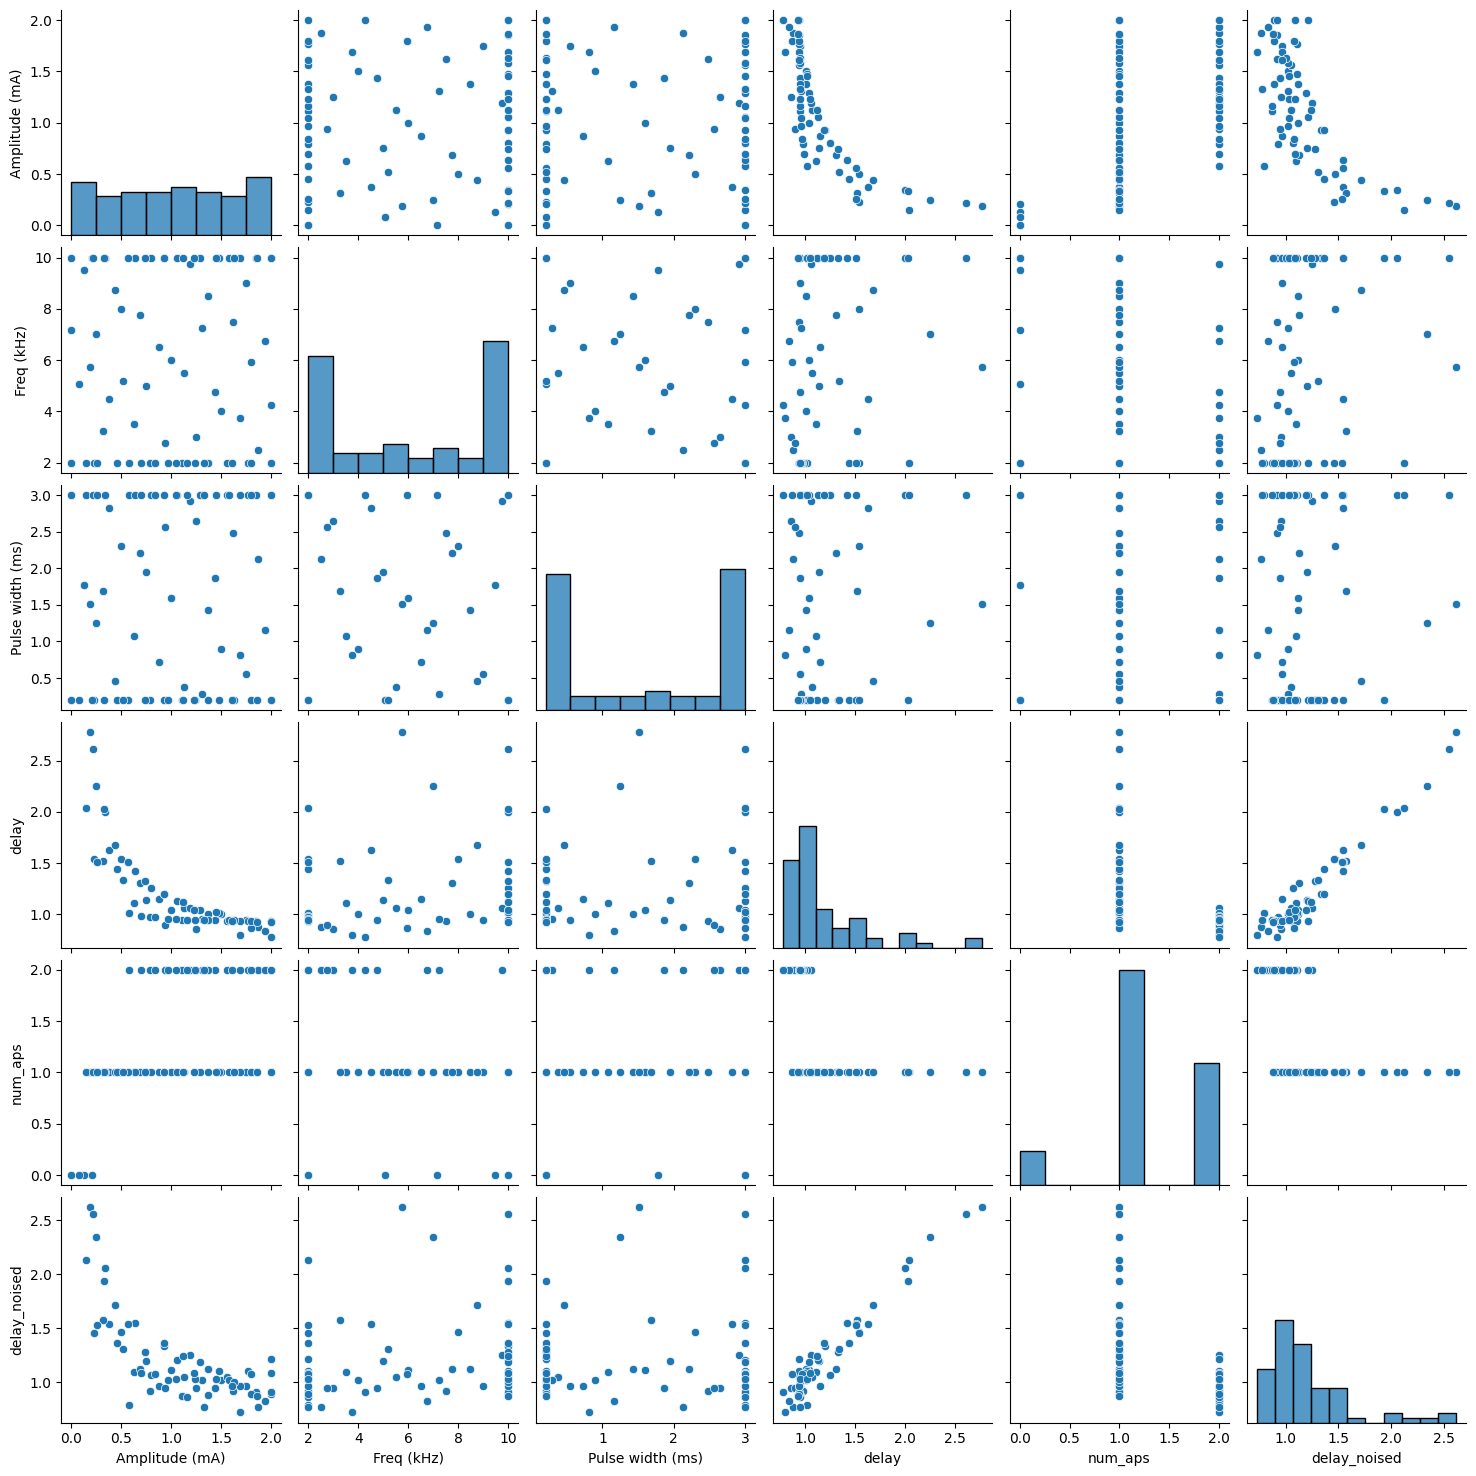

In [23]:
sns.pairplot(df_min_variance)

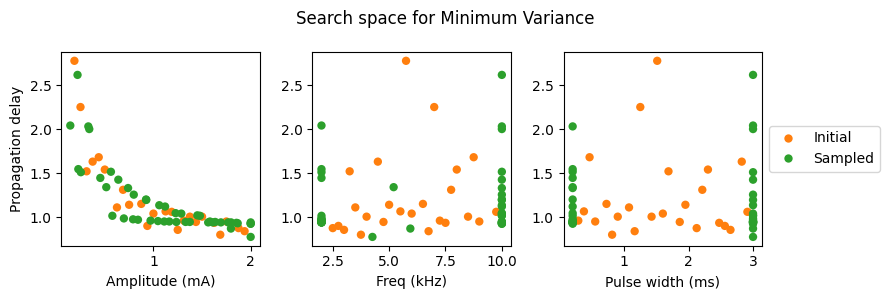

In [24]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))

colors = [
    'C1' if t == 'Initial' else 'C2'
    for t in df_min_variance['sample_type']
]

for e, col in enumerate(col_names):
    ax[e].scatter(df_min_variance[col], df_min_variance['delay'], c=colors, edgecolors='none')
    ax[e].set_xlabel(col)

# Legend: no white line, placed outside
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', label='Initial', 
           markerfacecolor='C1', markeredgecolor='none', markersize=6),
    Line2D([0], [0], marker='o', linestyle='None', label='Sampled', 
           markerfacecolor='C2', markeredgecolor='none', markersize=6)
]

# Place outside the last subplot
ax[-1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

ax[0].set_ylabel("Propagation delay")
fig.suptitle("Search space for Minimum Variance")
fig.tight_layout()
#fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust space to fit legend
plt.show()

### Optimizing for a delay
This model focuses in minimizing an objective function using ExpectedImprovement. We modify the objective so that the goal is to find the best parameters to match a target delay. In this case, the "desired" delay is 1.6 ms, as from the previous model it seems to have a very narrow set of optimal paramters (any other value could be selected here).

In [25]:
target_delay = 1.6

# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp_orig_scale)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp_orig_scale))

In [26]:
if NOISE_LEVEL>0:
    obs_label = np.array([o['delay_noised'] for o in observations]).reshape(-1,1)
else:
    obs_label = np.array([o['delay'] for o in observations]).reshape(-1,1)
    
obs_label[obs_label == np.inf] = 6
obs_label = np.abs(obs_label-target_delay)

init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(obs_label, tf.float64))


In [27]:
# Build model
model_config = {
    'classification': False,
    'variational': False,
    'sparse': False,
    'trainable_likelihood': True,
    'likelihood_variance':1e-5,
    'kernel_variance': None
}

online_model = online_learning.build_model(init_dataset, search_space, model_config)

# Set up acquisition function and rule
acq = AugmentedExpectedImprovement()
rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True
                                   )

In [28]:
# Optimization loop as for a next point to query
iter = 0

while iter <= max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')
    
    next_point = ask_tell.ask()
    
    if next_point is not None:
        qp_minmax_new = next_point.numpy()
    else:
        raise ValueError("ask_tell returned None - check optimizer setup")
    
    qp_new = scaler.inverse_transform(qp_minmax_new)
    if qp_new.ndim==1:
        qp_new = qp_new.reshape(-1, 1)
    stim_delays = len(qp_new)*[STIM_DELAY]

    # Run the simulation and get observations
    observations_new = sinusoid_delay_objective(mrg,
                                                stim_amp = qp_new[:, 0],
                                                stim_freq = qp_new[:, 1],
                                                stim_pw = qp_new[:, 2],
                                                stim_delay = stim_delays,
                                                meas_position = meas_position, 
                                                e_pos = stim_distance,
                                                abs_diff = False,
                                                sim_time = 4,
                                                plot_results = False,
                                                noise_level=NOISE_LEVEL)
            
    #obs_label = [o['stim_blocked'] for o in observations_new]
    if NOISE_LEVEL>0:
        obs_label = np.array([o['delay_noised'] for o in observations_new]).reshape(-1,1)
    else:
        obs_label = np.array([o['delay'] for o in observations_new]).reshape(-1,1)
    obs_label[obs_label == np.inf] = 6
    # Added to modify the target
    obs_label = np.abs(obs_label-target_delay)

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))
    
    # Create the new dataset
    tagged_output = Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(obs_label, tf.float64))
    
    # Update the optimizer with new data
    ask_tell.tell(tagged_output)
    iter += 1

# Save results
#ask_tell.save()

Config: Amp. 0.42 mA Freq. 7.08 KHz,  PW 2.54 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.31it/s]


{'delay': 1.659999999999965, 'num_aps': 1, 'delay_noised': 1.5927847793547951, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 325, 'component_end_time': 534, 'upward_line_coords': ((325, 67), (447, 1)), 'downward_line_coords': ((325, 67), (534, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 5, 'component_start_time': 401, 'component_end_time': 408, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 5, 'component_start_time': 432, 'component_end_time': 435, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 460, 'component_end_time': 464, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 226.13it/s]


{'delay': 1.4399999999999697, 'num_aps': 1, 'delay_noised': 1.4666448019762897, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 285, 'component_end_time': 490, 'upward_line_coords': ((285, 65), (403, 1)), 'downward_line_coords': ((285, 70), (490, 202)), 'y_span_at_start': 3, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 9, 'component_start_time': 337, 'component_end_time': 345, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 9, 'component_start_time': 361, 'component_end_time': 366, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 9, 'component_start_time': 384, 'component_end_time': 388, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 233.29it/s]


{'delay': 0.9399999999999804, 'num_aps': 2, 'delay_noised': 0.8275089850953603, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 181, 'component_end_time': 391, 'upward_line_coords': ((181, 67), (304, 1)), 'downward_line_coords': ((181, 68), (391, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 323, 'component_end_time': 349, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 405, 'component_end_time': 436, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 6, 'component_start_time': 487, 'component_end_time': 511, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 233.45it/s]


{'delay': inf, 'num_aps': 0, 'delay_noised': inf, 'ap_lines': []}
Config: Amp. 0.38 mA Freq. 2.00 KHz,  PW 1.59 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 228.34it/s]


{'delay': 1.4599999999999693, 'num_aps': 1, 'delay_noised': 1.489233868528733, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 280, 'component_end_time': 494, 'upward_line_coords': ((280, 67), (408, 1)), 'downward_line_coords': ((280, 67), (494, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 367, 'component_end_time': 383, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 3, 'component_start_time': 467, 'component_end_time': 494, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 0.49 mA Freq. 2.00 KHz,  PW 2.66 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 236.64it/s]


{'delay': 1.1399999999999761, 'num_aps': 2, 'delay_noised': 1.0745083276783025, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 231, 'component_end_time': 431, 'upward_line_coords': ((231, 62), (344, 1)), 'downward_line_coords': ((231, 72), (431, 202)), 'y_span_at_start': 3, 'min_y_at_start': 62, 'max_y_at_start': 72}, {'label': 4, 'total_of_features': 5, 'component_start_time': 368, 'component_end_time': 390, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 5, 'component_start_time': 464, 'component_end_time': 496, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 5, 'component_start_time': 578, 'component_end_time': 681, 'upward_line_coords': ((578, 49), (681, 1)), 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 49, 'max_

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 242.10it/s]


{'delay': 1.8249999999999615, 'num_aps': 1, 'delay_noised': 1.7409403244700836, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 358, 'component_end_time': 567, 'upward_line_coords': ((358, 67), (480, 1)), 'downward_line_coords': ((358, 68), (567, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 6, 'component_start_time': 412, 'component_end_time': 420, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 434, 'component_end_time': 438, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 455, 'component_end_time': 457, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 214.34it/s]


{'delay': 1.4549999999999694, 'num_aps': 1, 'delay_noised': 1.7269296131759422, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 278, 'component_end_time': 493, 'upward_line_coords': ((278, 67), (406, 1)), 'downward_line_coords': ((278, 67), (493, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 366, 'component_end_time': 385, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 3, 'component_start_time': 466, 'component_end_time': 495, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 0.31 mA Freq. 4.56 KHz,  PW 2.66 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 232.17it/s]


{'delay': 1.8249999999999615, 'num_aps': 1, 'delay_noised': 1.7632672942390686, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 357, 'component_end_time': 568, 'upward_line_coords': ((357, 67), (481, 1)), 'downward_line_coords': ((357, 68), (568, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 2, 'component_start_time': 437, 'component_end_time': 444, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.57 mA Freq. 5.53 KHz,  PW 0.52 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 230.27it/s]


{'delay': 1.289999999999973, 'num_aps': 1, 'delay_noised': 1.1907534103462887, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 257, 'component_end_time': 460, 'upward_line_coords': ((257, 63), (374, 1)), 'downward_line_coords': ((257, 71), (460, 202)), 'y_span_at_start': 6, 'min_y_at_start': 63, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 7, 'component_start_time': 301, 'component_end_time': 316, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 4, 'total_of_features': 7, 'component_start_time': 342, 'component_end_time': 349, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 7, 'component_start_time': 379, 'component_end_time': 386, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 217.78it/s]


{'delay': 1.9749999999999583, 'num_aps': 1, 'delay_noised': 2.0909172092866166, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 394, 'component_end_time': 597, 'upward_line_coords': ((394, 64), (510, 1)), 'downward_line_coords': ((394, 71), (597, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}]}
Config: Amp. 0.36 mA Freq. 4.49 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 230.06it/s]


{'delay': 1.6449999999999654, 'num_aps': 1, 'delay_noised': 1.5127923248832162, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 323, 'component_end_time': 531, 'upward_line_coords': ((323, 67), (444, 1)), 'downward_line_coords': ((323, 68), (531, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 3, 'component_start_time': 397, 'component_end_time': 406, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 490, 'component_end_time': 496, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.25 mA Freq. 2.63 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 235.11it/s]


{'delay': 1.6699999999999648, 'num_aps': 1, 'delay_noised': 1.6840947777458544, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 327, 'component_end_time': 536, 'upward_line_coords': ((327, 67), (449, 1)), 'downward_line_coords': ((327, 68), (536, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 0.48 mA Freq. 10.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 243.33it/s]


{'delay': 1.6349999999999656, 'num_aps': 1, 'delay_noised': 1.5353221074521708, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 324, 'component_end_time': 529, 'upward_line_coords': ((324, 65), (443, 1)), 'downward_line_coords': ((324, 69), (529, 202)), 'y_span_at_start': 2, 'min_y_at_start': 65, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 240.73it/s]


{'delay': 0.9799999999999796, 'num_aps': 1, 'delay_noised': 1.022391894074879, 'ap_lines': [{'label': 1, 'total_of_features': 21, 'component_start_time': 192, 'component_end_time': 398, 'upward_line_coords': ((192, 67), (311, 1)), 'downward_line_coords': ((192, 68), (398, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 21, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 21, 'component_start_time': 273, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 21, 'component_start_time': 293, 'component_end_time': 300, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 229.99it/s]


{'delay': 1.1399999999999761, 'num_aps': 1, 'delay_noised': 1.185345801088372, 'ap_lines': [{'label': 1, 'total_of_features': 13, 'component_start_time': 225, 'component_end_time': 430, 'upward_line_coords': ((225, 64), (343, 1)), 'downward_line_coords': ((225, 71), (430, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 13, 'component_start_time': 272, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 13, 'component_start_time': 293, 'component_end_time': 299, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 13, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 226.00it/s]


{'delay': 1.5149999999999681, 'num_aps': 1, 'delay_noised': 1.660687915415641, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 296, 'component_end_time': 506, 'upward_line_coords': ((296, 67), (419, 1)), 'downward_line_coords': ((296, 68), (506, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 9, 'component_start_time': 352, 'component_end_time': 360, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 9, 'component_start_time': 374, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 9, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 238.63it/s]


{'delay': 1.8349999999999613, 'num_aps': 1, 'delay_noised': 1.9993298679803682, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 358, 'component_end_time': 569, 'upward_line_coords': ((358, 67), (482, 1)), 'downward_line_coords': ((358, 68), (569, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 0.23 mA Freq. 2.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 235.73it/s]


{'delay': 1.5349999999999677, 'num_aps': 1, 'delay_noised': 1.5910215286709912, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 302, 'component_end_time': 510, 'upward_line_coords': ((302, 67), (423, 1)), 'downward_line_coords': ((302, 68), (510, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 2, 'component_start_time': 362, 'component_end_time': 375, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.32 mA Freq. 2.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 236.88it/s]


{'delay': 1.474999999999969, 'num_aps': 1, 'delay_noised': 1.3664153722529666, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 284, 'component_end_time': 497, 'upward_line_coords': ((284, 67), (410, 1)), 'downward_line_coords': ((284, 67), (497, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 3, 'component_start_time': 372, 'component_end_time': 377, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 469, 'component_end_time': 492, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.23 mA Freq. 2.00 KHz,  PW 1.42 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 241.65it/s]


{'delay': 1.5399999999999676, 'num_aps': 1, 'delay_noised': 1.6108547266933864, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 303, 'component_end_time': 510, 'upward_line_coords': ((303, 66), (423, 1)), 'downward_line_coords': ((303, 69), (510, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 2, 'component_start_time': 360, 'component_end_time': 375, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.39 mA Freq. 5.74 KHz,  PW 1.48 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 238.69it/s]


{'delay': 1.5999999999999663, 'num_aps': 1, 'delay_noised': 1.5223980192714284, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 318, 'component_end_time': 522, 'upward_line_coords': ((318, 64), (436, 1)), 'downward_line_coords': ((318, 70), (522, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 5, 'component_start_time': 363, 'component_end_time': 378, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 5, 'component_start_time': 404, 'component_end_time': 408, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 441, 'component_end_time': 443, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 237.94it/s]


{'delay': 1.5949999999999664, 'num_aps': 1, 'delay_noised': 1.6119446835851048, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 314, 'component_end_time': 521, 'upward_line_coords': ((314, 67), (434, 1)), 'downward_line_coords': ((314, 68), (521, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 239.56it/s]


{'delay': 1.2599999999999736, 'num_aps': 1, 'delay_noised': 0.9971988850423565, 'ap_lines': [{'label': 1, 'total_of_features': 11, 'component_start_time': 251, 'component_end_time': 455, 'upward_line_coords': ((251, 63), (368, 1)), 'downward_line_coords': ((251, 71), (455, 202)), 'y_span_at_start': 9, 'min_y_at_start': 63, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 11, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 11, 'component_start_time': 334, 'component_end_time': 339, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 9, 'total_of_features': 11, 'component_start_time': 354, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 230.64it/s]


{'delay': 1.5349999999999677, 'num_aps': 1, 'delay_noised': 1.6089505109541338, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 305, 'component_end_time': 510, 'upward_line_coords': ((305, 64), (423, 1)), 'downward_line_coords': ((305, 70), (510, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 9, 'component_start_time': 352, 'component_end_time': 360, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 9, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 9, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 242.33it/s]


{'delay': 1.5499999999999674, 'num_aps': 1, 'delay_noised': 1.6405321541322477, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 309, 'component_end_time': 513, 'upward_line_coords': ((309, 64), (426, 1)), 'downward_line_coords': ((309, 71), (513, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 3, 'component_start_time': 379, 'component_end_time': 388, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 482, 'component_end_time': 487, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.25 mA Freq. 2.00 KHz,  PW 1.99 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 245.05it/s]


{'delay': 1.5099999999999683, 'num_aps': 1, 'delay_noised': 1.4709989420636462, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 294, 'component_end_time': 504, 'upward_line_coords': ((294, 67), (417, 1)), 'downward_line_coords': ((294, 67), (504, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 2, 'component_start_time': 477, 'component_end_time': 485, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.74 mA Freq. 10.00 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 245.31it/s]


{'delay': 1.329999999999972, 'num_aps': 1, 'delay_noised': 1.2936774000682354, 'ap_lines': [{'label': 1, 'total_of_features': 11, 'component_start_time': 258, 'component_end_time': 468, 'upward_line_coords': ((258, 67), (381, 1)), 'downward_line_coords': ((258, 67), (468, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 11, 'component_start_time': 312, 'component_end_time': 320, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 11, 'component_start_time': 333, 'component_end_time': 339, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 11, 'component_start_time': 354, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 243.04it/s]


{'delay': 1.5399999999999676, 'num_aps': 1, 'delay_noised': 1.7871879395960533, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 302, 'component_end_time': 510, 'upward_line_coords': ((302, 67), (423, 1)), 'downward_line_coords': ((302, 68), (510, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 2, 'component_start_time': 362, 'component_end_time': 375, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.22 mA Freq. 2.00 KHz,  PW 2.61 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 237.44it/s]


{'delay': 1.569999999999967, 'num_aps': 1, 'delay_noised': 1.7147797814672727, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 311, 'component_end_time': 516, 'upward_line_coords': ((311, 65), (429, 1)), 'downward_line_coords': ((311, 69), (516, 202)), 'y_span_at_start': 5, 'min_y_at_start': 65, 'max_y_at_start': 69}]}
Config: Amp. 1.07 mA Freq. 2.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.64it/s]


{'delay': 0.9549999999999801, 'num_aps': 2, 'delay_noised': 1.0028836189527055, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 177, 'component_end_time': 393, 'upward_line_coords': ((177, 67), (306, 1)), 'downward_line_coords': ((177, 67), (393, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 6, 'component_start_time': 259, 'component_end_time': 293, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 361, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 6, 'component_start_time': 457, 'component_end_time': 498, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 229.17it/s]


{'delay': 1.6399999999999655, 'num_aps': 1, 'delay_noised': 1.5878072859657406, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 326, 'component_end_time': 531, 'upward_line_coords': ((326, 64), (444, 1)), 'downward_line_coords': ((326, 71), (531, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 8, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 235.92it/s]


{'delay': 1.4349999999999699, 'num_aps': 1, 'delay_noised': 1.510398822442878, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 284, 'component_end_time': 489, 'upward_line_coords': ((284, 65), (402, 1)), 'downward_line_coords': ((284, 70), (489, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 10, 'component_start_time': 332, 'component_end_time': 340, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 10, 'component_start_time': 353, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 10, 'component_start_time': 374, 'component_end_time': 378, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 225.02it/s]


{'delay': 1.474999999999969, 'num_aps': 1, 'delay_noised': 1.4377139118211086, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 284, 'component_end_time': 497, 'upward_line_coords': ((284, 67), (410, 1)), 'downward_line_coords': ((284, 68), (497, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 3, 'component_start_time': 371, 'component_end_time': 378, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 469, 'component_end_time': 493, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 1.21 mA Freq. 10.00 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 243.35it/s]


{'delay': 1.049999999999978, 'num_aps': 1, 'delay_noised': 1.1508259071934615, 'ap_lines': [{'label': 1, 'total_of_features': 14, 'component_start_time': 208, 'component_end_time': 412, 'upward_line_coords': ((208, 64), (326, 1)), 'downward_line_coords': ((208, 71), (412, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 14, 'component_start_time': 251, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 14, 'component_start_time': 273, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 14, 'component_start_time': 293, 'component_end_time': 299, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 236.45it/s]


{'delay': 1.7199999999999638, 'num_aps': 1, 'delay_noised': 1.743528162361406, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 337, 'component_end_time': 546, 'upward_line_coords': ((337, 67), (460, 1)), 'downward_line_coords': ((337, 68), (546, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 7, 'component_start_time': 392, 'component_end_time': 400, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 414, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 435, 'component_end_time': 438, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, 

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 196.69it/s]


{'delay': 1.5149999999999681, 'num_aps': 1, 'delay_noised': 1.6144205882941365, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 301, 'component_end_time': 505, 'upward_line_coords': ((301, 64), (418, 1)), 'downward_line_coords': ((301, 71), (505, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 5, 'component_start_time': 352, 'component_end_time': 366, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 5, 'component_start_time': 397, 'component_end_time': 400, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 436, 'component_end_time': 439, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 215.27it/s]


{'delay': 1.5949999999999664, 'num_aps': 1, 'delay_noised': 1.6499770730765617, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 314, 'component_end_time': 521, 'upward_line_coords': ((314, 67), (434, 1)), 'downward_line_coords': ((314, 68), (521, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 217.71it/s]


{'delay': 1.5299999999999678, 'num_aps': 1, 'delay_noised': 1.4334713942911639, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 303, 'component_end_time': 509, 'upward_line_coords': ((303, 69), (422, 1)), 'downward_line_coords': ((303, 69), (509, 202)), 'y_span_at_start': 1, 'min_y_at_start': 69, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 9, 'component_start_time': 352, 'component_end_time': 360, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 9, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 9, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 222.95it/s]


{'delay': 1.5399999999999676, 'num_aps': 1, 'delay_noised': 1.553581154410557, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 305, 'component_end_time': 510, 'upward_line_coords': ((305, 64), (423, 1)), 'downward_line_coords': ((305, 70), (510, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 9, 'component_start_time': 352, 'component_end_time': 360, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 9, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 9, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 215.14it/s]


{'delay': 1.4649999999999692, 'num_aps': 1, 'delay_noised': 1.3797794808015718, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 291, 'component_end_time': 495, 'upward_line_coords': ((291, 64), (408, 1)), 'downward_line_coords': ((291, 71), (495, 202)), 'y_span_at_start': 8, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 9, 'component_start_time': 353, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 9, 'component_start_time': 374, 'component_end_time': 378, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 9, 'component_start_time': 395, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 226.51it/s]


{'delay': 1.3649999999999713, 'num_aps': 1, 'delay_noised': 1.3432671617260572, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 271, 'component_end_time': 475, 'upward_line_coords': ((271, 64), (388, 1)), 'downward_line_coords': ((271, 71), (475, 202)), 'y_span_at_start': 8, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 10, 'component_start_time': 333, 'component_end_time': 339, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 10, 'component_start_time': 354, 'component_end_time': 358, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 10, 'component_start_time': 374, 'component_end_time': 378, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 222.29it/s]


{'delay': 1.4549999999999694, 'num_aps': 1, 'delay_noised': 1.413443863560375, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 279, 'component_end_time': 494, 'upward_line_coords': ((279, 67), (407, 1)), 'downward_line_coords': ((279, 68), (494, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 3, 'component_start_time': 366, 'component_end_time': 384, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 3, 'component_start_time': 466, 'component_end_time': 495, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 1.31 mA Freq. 10.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.11it/s]


{'delay': 1.0349999999999784, 'num_aps': 1, 'delay_noised': 1.025709264395883, 'ap_lines': [{'label': 1, 'total_of_features': 18, 'component_start_time': 204, 'component_end_time': 410, 'upward_line_coords': ((204, 65), (323, 1)), 'downward_line_coords': ((204, 65), (410, 202)), 'y_span_at_start': 1, 'min_y_at_start': 65, 'max_y_at_start': 65}, {'label': 4, 'total_of_features': 18, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 18, 'component_start_time': 265, 'component_end_time': 265, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 61, 'max_y_at_start': 62}, {'label': 18, 'total_of_features': 18, 'component_start_time': 265, 'component_end_time': 265, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 73, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 222.49it/s]


{'delay': 1.1199999999999766, 'num_aps': 1, 'delay_noised': 1.0300215777903456, 'ap_lines': [{'label': 1, 'total_of_features': 13, 'component_start_time': 216, 'component_end_time': 427, 'upward_line_coords': ((216, 67), (340, 1)), 'downward_line_coords': ((216, 67), (427, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 13, 'component_start_time': 272, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 13, 'component_start_time': 293, 'component_end_time': 299, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 13, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 234.87it/s]


{'delay': 0.9749999999999797, 'num_aps': 1, 'delay_noised': 1.121464000927869, 'ap_lines': [{'label': 1, 'total_of_features': 22, 'component_start_time': 192, 'component_end_time': 397, 'upward_line_coords': ((192, 66), (310, 1)), 'downward_line_coords': ((192, 69), (397, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 6, 'total_of_features': 22, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 22, 'component_start_time': 273, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 22, 'component_start_time': 293, 'component_end_time': 300, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 238.08it/s]


{'delay': 0.9399999999999804, 'num_aps': 2, 'delay_noised': 0.9780220212603042, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 169, 'component_end_time': 390, 'upward_line_coords': ((169, 67), (303, 1)), 'downward_line_coords': ((169, 68), (390, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 10, 'component_start_time': 256, 'component_end_time': 298, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 6, 'total_of_features': 10, 'component_start_time': 358, 'component_end_time': 400, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 10, 'component_start_time': 412, 'component_end_time': 445, 'upward_line_coords': ((412, 62), (442, 52)), 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 62, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 230.63it/s]


{'delay': 0.9249999999999807, 'num_aps': 1, 'delay_noised': 0.9949830049022662, 'ap_lines': [{'label': 1, 'total_of_features': 31, 'component_start_time': 176, 'component_end_time': 387, 'upward_line_coords': ((176, 67), (300, 1)), 'downward_line_coords': ((176, 68), (387, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 10, 'total_of_features': 31, 'component_start_time': 232, 'component_end_time': 240, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 31, 'component_start_time': 244, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 61, 'max_y_at_start': 62}, {'label': 31, 'total_of_features': 31, 'component_start_time': 244, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 72, 'max_y_at_start'

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 232.96it/s]


{'delay': 1.1649999999999756, 'num_aps': 1, 'delay_noised': 1.0937012428310209, 'ap_lines': [{'label': 1, 'total_of_features': 12, 'component_start_time': 231, 'component_end_time': 435, 'upward_line_coords': ((231, 64), (349, 1)), 'downward_line_coords': ((231, 70), (435, 202)), 'y_span_at_start': 7, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 12, 'component_start_time': 293, 'component_end_time': 299, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 12, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 12, 'total_of_features': 12, 'component_start_time': 334, 'component_end_time': 339, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start':

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 233.41it/s]


{'delay': 1.6699999999999648, 'num_aps': 1, 'delay_noised': 1.758699857695438, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 331, 'component_end_time': 536, 'upward_line_coords': ((331, 65), (449, 1)), 'downward_line_coords': ((331, 70), (536, 202)), 'y_span_at_start': 2, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 4, 'component_start_time': 409, 'component_end_time': 415, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 444, 'component_end_time': 445, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 476, 'component_end_time': 478, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 237.36it/s]


{'delay': 1.5749999999999669, 'num_aps': 1, 'delay_noised': 1.6183062562321202, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 308, 'component_end_time': 517, 'upward_line_coords': ((308, 67), (431, 1)), 'downward_line_coords': ((308, 67), (517, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 5, 'component_start_time': 365, 'component_end_time': 377, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 5, 'component_start_time': 404, 'component_end_time': 409, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 440, 'component_end_time': 445, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

In [29]:
# Concatenate all data
all_qp_array = np.vstack(all_qp)
df_all_observations = [d for sublist in all_observations for d in sublist]
df_all_observations = pd.DataFrame(df_all_observations)
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
col_names = ['Amplitude (mA)', 'Pulse width (ms)', 'Delay (ms)']
df_min_target = pd.DataFrame(all_qp_array, columns=col_names)
df_min_target['sample_type'] = all_sample_types_array
df_min_target = pd.concat([df_min_target, df_all_observations],axis=1)
df_min_target['Loss (MAE)'] = np.abs(df_min_target['delay'] - target_delay)

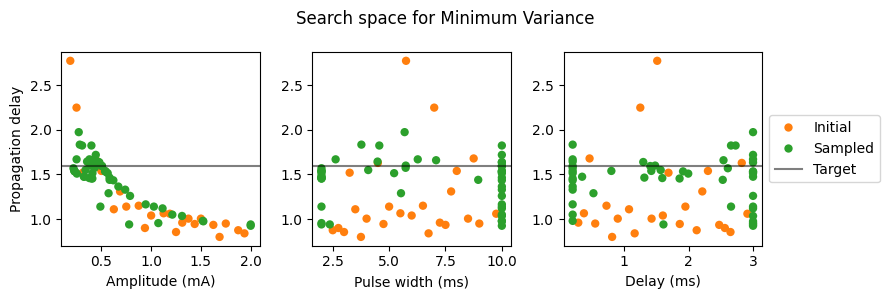

In [30]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))
colors = [
    'C1' if t == 'Initial' else 'C2'
    for t in df_min_target['sample_type']
]

for e, col in enumerate(col_names):
    ax[e].scatter(df_min_target[col], df_min_target['delay'], c=colors, edgecolors='none')
    ax[e].axhline(target_delay, color='k', alpha=0.5, label='Target {target_delay:.2f}')
    ax[e].set_xlabel(col)

# Legend: no white line, placed outside
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', label='Initial', 
           markerfacecolor='C1', markeredgecolor='none', markersize=6),
    Line2D([0], [0], marker='o', linestyle='None', label='Sampled', 
           markerfacecolor='C2', markeredgecolor='none', markersize=6),
    Line2D([0], [0], color='k', alpha=0.5, label='Target')

]

# Place outside the last subplot
ax[-1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

ax[0].set_ylabel("Propagation delay")
fig.suptitle("Search space for Minimum Variance")
fig.tight_layout()
#fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust space to fit legend
plt.show()

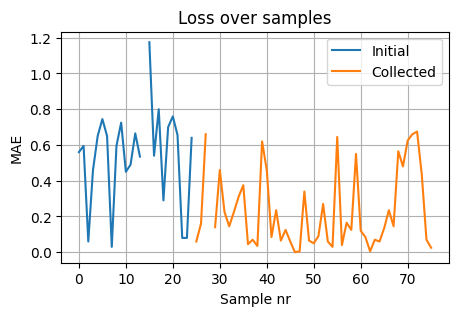

In [31]:
fig, ax = plt.subplots(figsize=(5,3))
sub_df_0 = df_min_target.loc[df_min_target['sample_type']=='Initial']
sub_df_1 = df_min_target.loc[~(df_min_target['sample_type']=='Initial')]
ax.plot(np.arange(len(sub_df_0)), sub_df_0['Loss (MAE)'], label='Initial')
ax.plot(np.arange(len(sub_df_0), len(df_min_target)), sub_df_1['Loss (MAE)'], label='Collected')
ax.set_title("Loss over samples")
ax.set_xlabel("Sample nr")
ax.set_ylabel("MAE")
ax.grid()
ax.legend()


Text(0.5, 0.98, 'Distribution of APs')

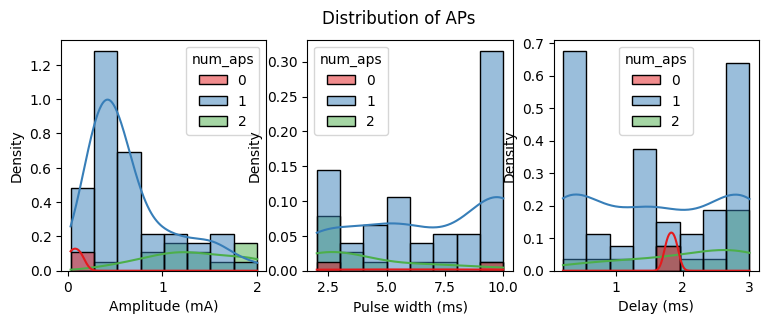

In [32]:
fig, ax = plt.subplots(ncols=3, figsize=(9,3))
for e, col in enumerate(col_names):
    sns.histplot(data=df_min_target, x=col, hue='num_aps',
                 kde=True,
                 #element='step',
                 stat='density',
                 common_norm=True,
                 palette='Set1',
                 ax=ax[e])

    ax[e].set_xlabel(col)
fig.suptitle("Distribution of APs")

## Optimization with constraints

Assume that, hypothetically, we would like to guarantee that only one AP is activated. Say that experiments with no APs are not informative, and that with 2 APs can damage the nerve. This can be approached in multiple ways, here we opt for Feasibility region and focus on optimizing a threshold (as in the last example) while preventing triggering 0, 2 or more than 2 APs.
We extend the first scenario: we want to minimize global uncertainty (Notice that we could also reproduce scenario 2)


In [33]:
# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp_orig_scale)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp_orig_scale))

In [34]:
if NOISE_LEVEL>0:
    obs_label = np.array([o['delay_noised'] for o in observations]).reshape(-1,1)
else:
    obs_label = np.array([o['delay'] for o in observations]).reshape(-1,1)
obs_label[obs_label==np.inf] = 6
obs_label = np.abs(obs_label-target_delay)

constraint = np.array([obs['num_aps'] for obs in observations])==1
constraint = constraint.astype(int).reshape(-1,1)

init_dataset_objective = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                                 observations=tf.cast(obs_label, tf.float64))

init_dataset_constraint = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                                 observations=tf.cast(constraint, tf.float64))

init_dataset = {
    "OBJECTIVE" : init_dataset_objective,
    "CONSTRAINT" : init_dataset_constraint
}



In [35]:
# Build model
class ProbabilityOfValidity(SingleModelAcquisitionBuilder):
    def prepare_acquisition_function(self, model, dataset='CONSTRAINT'):
        def acquisition(at):
            mean, _ = model.predict_y(tf.squeeze(at, -2))
            return mean
        return acquisition
    
model_config = {
    'classification': False,
    'variational': False,
    'sparse': False,
    'trainable_likelihood': True,
    'kernel_variance': None
}

objective_model = online_learning.build_model(init_dataset['OBJECTIVE'], search_space, model_config)

# Classification is True for the Contrained model
model_config = {
    'classification': True,
    'variational': True,
    'sparse': False,
    'trainable_likelihood': True,
    'noise_free': False, # The constraint is noiselesss as the CAP occurs regardless of the noise estimate,
    'kernel_variance': None
}
constraint_model = online_learning.build_model(init_dataset["CONSTRAINT"], search_space, model_config)

online_models = {"OBJECTIVE": objective_model,
                 "CONSTRAINT": constraint_model
                 }

    
# Set up acquisition function and rule
acq0 = AugmentedExpectedImprovement()
acq1 = ExpectedFeasibility(threshold=0.5, delta=1)
acq1 = ProbabilityOfValidity()
#acq1 = BayesianActiveLearningByDisagreement()

combined_acquisition = Product(acq0.using("OBJECTIVE"), acq1.using("CONSTRAINT"))
rule = EfficientGlobalOptimization(combined_acquisition, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_models,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   #overwrite=True,
                                   #track_path='nerve_block'
                                   )

In [36]:
# Optimization loop as for a next point to query

iter = 0
while iter <= max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')
    
    next_point = ask_tell.ask()
    
    if next_point is not None:
        qp_minmax_new = next_point.numpy()
    else:
        raise ValueError("ask_tell returned None - check optimizer setup")
    
    qp_new = scaler.inverse_transform(qp_minmax_new)
    if qp_new.ndim==1:
        qp_new = qp_new.reshape(-1, 1)
    stim_delays = len(qp_new)*[STIM_DELAY]

    # Run the simulation and get observations
    observations_new = sinusoid_delay_objective(mrg,
                                            stim_amp = qp_new[:, 0],
                                            stim_freq = qp_new[:, 1],
                                            stim_pw = qp_new[:, 2],
                                            stim_delay = stim_delays,
                                            meas_position = meas_position, 
                                            e_pos = stim_distance,
                                            abs_diff = False,
                                            sim_time = 4,
                                            plot_results = False,
                                            noise_level=NOISE_LEVEL)
            
    if NOISE_LEVEL>0:
        obs_label = np.array([o['delay_noised'] for o in observations_new]).reshape(-1,1)
    else:
        obs_label = np.array([o['delay'] for o in observations_new]).reshape(-1,1)
    
    obs_label[obs_label == np.inf] = 6    
    obs_label = np.abs(obs_label-target_delay)

    constraint = np.array([obs['num_aps'] for obs in observations_new])==1
    constraint = constraint.astype(int).reshape(-1,1)

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))
    
    # Create the new dataset
    tagged_output = {"OBJECTIVE":Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                                         observations=tf.cast(obs_label, tf.float64)),
                     "CONSTRAINT":Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                                          observations=tf.cast(constraint, tf.float64))
    }
    
    # Update the optimizer with new data
    ask_tell.tell(tagged_output)
    iter += 1

# Save results
#ask_tell.save()

Config: Amp. 0.47 mA Freq. 7.25 KHz,  PW 2.53 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 229.32it/s]


{'delay': 1.524999999999968, 'num_aps': 1, 'delay_noised': 1.491528563836264, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 304, 'component_end_time': 508, 'upward_line_coords': ((304, 63), (421, 1)), 'downward_line_coords': ((304, 71), (508, 202)), 'y_span_at_start': 7, 'min_y_at_start': 63, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 6, 'component_start_time': 366, 'component_end_time': 374, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 396, 'component_end_time': 400, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 424, 'component_end_time': 428, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 228.84it/s]


{'delay': 1.2049999999999748, 'num_aps': 2, 'delay_noised': 1.1241178195700074, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 228, 'component_end_time': 443, 'upward_line_coords': ((228, 67), (356, 1)), 'downward_line_coords': ((228, 68), (443, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 282, 'component_end_time': 312, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 361, 'component_end_time': 383, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 7, 'component_start_time': 431, 'component_end_time': 457, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 223.78it/s]


{'delay': 2.2849999999999517, 'num_aps': 1, 'delay_noised': 2.3092834867382344, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 448, 'component_end_time': 659, 'upward_line_coords': ((448, 67), (572, 1)), 'downward_line_coords': ((448, 68), (659, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 0.51 mA Freq. 6.58 KHz,  PW 2.89 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 193.01it/s]


{'delay': 1.4549999999999694, 'num_aps': 1, 'delay_noised': 1.572595577795712, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 288, 'component_end_time': 493, 'upward_line_coords': ((288, 65), (406, 1)), 'downward_line_coords': ((288, 70), (493, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 6, 'component_start_time': 364, 'component_end_time': 371, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 396, 'component_end_time': 400, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 426, 'component_end_time': 432, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 208.54it/s]


{'delay': inf, 'num_aps': 0, 'delay_noised': inf, 'ap_lines': []}
Config: Amp. 0.32 mA Freq. 5.06 KHz,  PW 0.45 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 212.24it/s]


{'delay': 1.7349999999999635, 'num_aps': 1, 'delay_noised': 1.6550686478769767, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 344, 'component_end_time': 549, 'upward_line_coords': ((344, 65), (463, 1)), 'downward_line_coords': ((344, 69), (549, 202)), 'y_span_at_start': 3, 'min_y_at_start': 65, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 2, 'component_start_time': 400, 'component_end_time': 413, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.47 mA Freq. 4.47 KHz,  PW 2.49 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 214.44it/s]


{'delay': 1.42499999999997, 'num_aps': 1, 'delay_noised': 1.487366996715802, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 277, 'component_end_time': 487, 'upward_line_coords': ((277, 67), (400, 1)), 'downward_line_coords': ((277, 67), (487, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 5, 'component_start_time': 353, 'component_end_time': 364, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 5, 'component_start_time': 401, 'component_end_time': 408, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 445, 'component_end_time': 455, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 226.38it/s]


{'delay': 1.8349999999999613, 'num_aps': 1, 'delay_noised': 1.86304900992694, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 360, 'component_end_time': 570, 'upward_line_coords': ((360, 67), (483, 1)), 'downward_line_coords': ((360, 67), (570, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.32 mA Freq. 4.72 KHz,  PW 1.48 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.25it/s]


{'delay': 1.7949999999999622, 'num_aps': 1, 'delay_noised': 1.7418737343475268, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 352, 'component_end_time': 562, 'upward_line_coords': ((352, 67), (475, 1)), 'downward_line_coords': ((352, 67), (562, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 2, 'component_start_time': 425, 'component_end_time': 434, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 0.34 mA Freq. 2.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 224.43it/s]


{'delay': 1.469999999999969, 'num_aps': 1, 'delay_noised': 1.4499829478551287, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 283, 'component_end_time': 496, 'upward_line_coords': ((283, 67), (409, 1)), 'downward_line_coords': ((283, 68), (496, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 3, 'component_start_time': 370, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 3, 'component_start_time': 468, 'component_end_time': 493, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.38 mA Freq. 3.95 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 225.19it/s]


{'delay': 1.5399999999999676, 'num_aps': 1, 'delay_noised': 1.677499363212324, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 301, 'component_end_time': 510, 'upward_line_coords': ((301, 67), (424, 1)), 'downward_line_coords': ((301, 68), (510, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 390, 'component_end_time': 396, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 442, 'component_end_time': 448, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 491, 'component_end_time': 500, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 232.48it/s]


{'delay': 1.5849999999999667, 'num_aps': 1, 'delay_noised': 1.5031035436731852, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 310, 'component_end_time': 520, 'upward_line_coords': ((310, 67), (433, 1)), 'downward_line_coords': ((310, 68), (520, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 6, 'component_start_time': 363, 'component_end_time': 375, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 397, 'component_end_time': 403, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 429, 'component_end_time': 433, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 216.27it/s]


{'delay': 1.5299999999999678, 'num_aps': 1, 'delay_noised': 1.5531389825682533, 'ap_lines': [{'label': 4, 'total_of_features': 10, 'component_start_time': 300, 'component_end_time': 300, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 1, 'total_of_features': 10, 'component_start_time': 302, 'component_end_time': 508, 'upward_line_coords': ((302, 66), (421, 1)), 'downward_line_coords': ((302, 66), (508, 202)), 'y_span_at_start': 1, 'min_y_at_start': 66, 'max_y_at_start': 66}, {'label': 2, 'total_of_features': 10, 'component_start_time': 352, 'component_end_time': 360, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 10, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 223.69it/s]


{'delay': 0.9649999999999799, 'num_aps': 1, 'delay_noised': 0.9260262705030057, 'ap_lines': [{'label': 1, 'total_of_features': 22, 'component_start_time': 191, 'component_end_time': 395, 'upward_line_coords': ((191, 65), (309, 1)), 'downward_line_coords': ((191, 70), (395, 202)), 'y_span_at_start': 6, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 6, 'total_of_features': 22, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 22, 'component_start_time': 273, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 22, 'component_start_time': 293, 'component_end_time': 300, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 218.12it/s]


{'delay': 0.9299999999999806, 'num_aps': 1, 'delay_noised': 0.8239595452662962, 'ap_lines': [{'label': 24, 'total_of_features': 32, 'component_start_time': 178, 'component_end_time': 181, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 1, 'total_of_features': 32, 'component_start_time': 183, 'component_end_time': 389, 'upward_line_coords': ((183, 65), (302, 1)), 'downward_line_coords': ((183, 70), (389, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 10, 'total_of_features': 32, 'component_start_time': 232, 'component_end_time': 240, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 32, 'component_start_time': 244, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 60, 'max_y_at_start'

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 225.46it/s]


{'delay': 1.1299999999999764, 'num_aps': 1, 'delay_noised': 1.11265743613395, 'ap_lines': [{'label': 1, 'total_of_features': 13, 'component_start_time': 218, 'component_end_time': 428, 'upward_line_coords': ((218, 67), (341, 1)), 'downward_line_coords': ((218, 68), (428, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 13, 'component_start_time': 272, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 13, 'component_start_time': 293, 'component_end_time': 299, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 13, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 226.78it/s]


{'delay': 1.479999999999969, 'num_aps': 1, 'delay_noised': 1.3789158142727762, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 293, 'component_end_time': 498, 'upward_line_coords': ((293, 65), (411, 1)), 'downward_line_coords': ((293, 70), (498, 202)), 'y_span_at_start': 6, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 2, 'component_start_time': 457, 'component_end_time': 462, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.37 mA Freq. 6.02 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 225.23it/s]


{'delay': 1.6999999999999642, 'num_aps': 1, 'delay_noised': 1.7596833701236947, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 337, 'component_end_time': 542, 'upward_line_coords': ((337, 65), (456, 1)), 'downward_line_coords': ((337, 70), (542, 202)), 'y_span_at_start': 6, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 5, 'component_start_time': 385, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 5, 'component_start_time': 423, 'component_end_time': 428, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 459, 'component_end_time': 460, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 224.53it/s]


{'delay': 1.5049999999999684, 'num_aps': 1, 'delay_noised': 1.3811009789017972, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 299, 'component_end_time': 503, 'upward_line_coords': ((299, 64), (416, 1)), 'downward_line_coords': ((299, 71), (503, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 8, 'component_start_time': 350, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 376, 'component_end_time': 381, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 400, 'component_end_time': 404, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 234.59it/s]


{'delay': 1.5349999999999677, 'num_aps': 1, 'delay_noised': 1.3842705361529464, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 305, 'component_end_time': 510, 'upward_line_coords': ((305, 64), (423, 1)), 'downward_line_coords': ((305, 70), (510, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 9, 'component_start_time': 352, 'component_end_time': 360, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 9, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 9, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 193.81it/s]


{'delay': 1.189999999999975, 'num_aps': 1, 'delay_noised': 1.154872876515088, 'ap_lines': [{'label': 1, 'total_of_features': 12, 'component_start_time': 233, 'component_end_time': 440, 'upward_line_coords': ((233, 67), (354, 1)), 'downward_line_coords': ((233, 68), (440, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 12, 'component_start_time': 292, 'component_end_time': 300, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 12, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 11, 'total_of_features': 12, 'component_start_time': 334, 'component_end_time': 339, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 191.11it/s]


{'delay': 1.2949999999999728, 'num_aps': 2, 'delay_noised': 1.4314087773839612, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 253, 'component_end_time': 461, 'upward_line_coords': ((253, 67), (374, 1)), 'downward_line_coords': ((253, 68), (461, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 4, 'component_start_time': 459, 'component_end_time': 478, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 4, 'component_start_time': 595, 'component_end_time': 667, 'upward_line_coords': ((595, 32), (667, 1)), 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 32, 'max_y_at_start': 33}, {'label': 4, 'total_of_features': 4, 'component_start_time': 596, 'component_end_time': 800, 'upward_line_coords': None, 'downward_line_coords': ((596, 103), (800, 202)), 'y_span_at_start': 1, 'min_y_

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 204.16it/s]


{'delay': 1.6349999999999656, 'num_aps': 1, 'delay_noised': 1.6748046356012642, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 324, 'component_end_time': 529, 'upward_line_coords': ((324, 65), (443, 1)), 'downward_line_coords': ((324, 69), (529, 202)), 'y_span_at_start': 2, 'min_y_at_start': 65, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 212.87it/s]


{'delay': 1.3449999999999718, 'num_aps': 1, 'delay_noised': 1.3867005503378533, 'ap_lines': [{'label': 1, 'total_of_features': 11, 'component_start_time': 267, 'component_end_time': 471, 'upward_line_coords': ((267, 64), (385, 1)), 'downward_line_coords': ((267, 71), (471, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 11, 'component_start_time': 312, 'component_end_time': 320, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 11, 'component_start_time': 333, 'component_end_time': 339, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 11, 'component_start_time': 354, 'component_end_time': 358, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 223.34it/s]


{'delay': 1.7199999999999638, 'num_aps': 1, 'delay_noised': 1.6670775119651822, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 340, 'component_end_time': 546, 'upward_line_coords': ((340, 66), (459, 1)), 'downward_line_coords': ((340, 69), (546, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}]}
Config: Amp. 0.27 mA Freq. 5.08 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 225.02it/s]


{'delay': 1.9299999999999593, 'num_aps': 1, 'delay_noised': 1.9564220312031055, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 384, 'component_end_time': 588, 'upward_line_coords': ((384, 64), (502, 1)), 'downward_line_coords': ((384, 71), (588, 202)), 'y_span_at_start': 7, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 2, 'component_start_time': 439, 'component_end_time': 451, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.26 mA Freq. 2.00 KHz,  PW 2.46 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 225.28it/s]


{'delay': 1.5049999999999684, 'num_aps': 1, 'delay_noised': 1.43853685227414, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 293, 'component_end_time': 503, 'upward_line_coords': ((293, 67), (416, 1)), 'downward_line_coords': ((293, 68), (503, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 2, 'component_start_time': 475, 'component_end_time': 487, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}


2025-10-16 11:08:53.774844: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Config: Amp. 0.38 mA Freq. 4.79 KHz,  PW 0.67 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 219.09it/s]


{'delay': 1.5849999999999667, 'num_aps': 1, 'delay_noised': 1.5917233908998718, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 312, 'component_end_time': 519, 'upward_line_coords': ((312, 66), (432, 1)), 'downward_line_coords': ((312, 68), (519, 202)), 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 377, 'component_end_time': 388, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 425, 'component_end_time': 426, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 466, 'component_end_time': 471, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.06it/s]


{'delay': 1.099999999999977, 'num_aps': 1, 'delay_noised': 1.0268891692561846, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 216, 'component_end_time': 423, 'upward_line_coords': ((216, 66), (336, 1)), 'downward_line_coords': ((216, 69), (423, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 4, 'total_of_features': 5, 'component_start_time': 305, 'component_end_time': 316, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 5, 'component_start_time': 361, 'component_end_time': 375, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 5, 'component_start_time': 415, 'component_end_time': 432, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 224.19it/s]


{'delay': 1.42499999999997, 'num_aps': 1, 'delay_noised': 1.3951960100434495, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 285, 'component_end_time': 487, 'upward_line_coords': ((285, 63), (400, 1)), 'downward_line_coords': ((285, 72), (487, 202)), 'y_span_at_start': 6, 'min_y_at_start': 63, 'max_y_at_start': 72}, {'label': 2, 'total_of_features': 6, 'component_start_time': 329, 'component_end_time': 346, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 378, 'component_end_time': 383, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 420, 'component_end_time': 426, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 226.18it/s]


{'delay': 1.469999999999969, 'num_aps': 1, 'delay_noised': 1.399376489661651, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 290, 'component_end_time': 497, 'upward_line_coords': ((290, 66), (410, 1)), 'downward_line_coords': ((290, 69), (497, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 2, 'component_start_time': 457, 'component_end_time': 464, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.29 mA Freq. 2.00 KHz,  PW 1.48 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 228.23it/s]


{'delay': 1.4899999999999687, 'num_aps': 1, 'delay_noised': 1.314012357997383, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 288, 'component_end_time': 500, 'upward_line_coords': ((288, 67), (413, 1)), 'downward_line_coords': ((288, 67), (500, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 2, 'component_start_time': 472, 'component_end_time': 490, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.61 mA Freq. 10.00 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 213.52it/s]


{'delay': 1.4399999999999697, 'num_aps': 1, 'delay_noised': 1.476404588131295, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 285, 'component_end_time': 490, 'upward_line_coords': ((285, 64), (403, 1)), 'downward_line_coords': ((285, 70), (490, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 10, 'component_start_time': 332, 'component_end_time': 340, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 10, 'component_start_time': 353, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 10, 'component_start_time': 374, 'component_end_time': 378, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 226.06it/s]


{'delay': 1.384999999999971, 'num_aps': 1, 'delay_noised': 1.3008011171182468, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 267, 'component_end_time': 479, 'upward_line_coords': ((267, 67), (392, 1)), 'downward_line_coords': ((267, 68), (479, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 4, 'component_start_time': 373, 'component_end_time': 384, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 431, 'component_end_time': 446, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 4, 'component_start_time': 487, 'component_end_time': 501, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.03it/s]


{'delay': 1.5299999999999678, 'num_aps': 1, 'delay_noised': 1.5565575773807558, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 301, 'component_end_time': 508, 'upward_line_coords': ((301, 67), (422, 1)), 'downward_line_coords': ((301, 68), (508, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 5, 'component_start_time': 364, 'component_end_time': 376, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 5, 'component_start_time': 408, 'component_end_time': 413, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 448, 'component_end_time': 454, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:05<00:00, 157.62it/s]


{'delay': 1.5399999999999676, 'num_aps': 1, 'delay_noised': 1.4324729897413513, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 305, 'component_end_time': 510, 'upward_line_coords': ((305, 65), (424, 1)), 'downward_line_coords': ((305, 70), (510, 202)), 'y_span_at_start': 5, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 3, 'component_start_time': 381, 'component_end_time': 388, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 483, 'component_end_time': 489, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.41 mA Freq. 6.17 KHz,  PW 0.78 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:05<00:00, 155.02it/s]


{'delay': 1.6549999999999652, 'num_aps': 1, 'delay_noised': 1.6581205064944193, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 324, 'component_end_time': 534, 'upward_line_coords': ((324, 67), (447, 1)), 'downward_line_coords': ((324, 68), (534, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 5, 'component_start_time': 378, 'component_end_time': 390, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 5, 'component_start_time': 415, 'component_end_time': 420, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 449, 'component_end_time': 452, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:08<00:00, 94.77it/s] 


{'delay': 1.4549999999999694, 'num_aps': 1, 'delay_noised': 1.5383739894552404, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 285, 'component_end_time': 493, 'upward_line_coords': ((285, 67), (406, 1)), 'downward_line_coords': ((285, 68), (493, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 6, 'component_start_time': 343, 'component_end_time': 356, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 384, 'component_end_time': 390, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 422, 'component_end_time': 428, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:08<00:00, 97.12it/s] 


{'delay': 1.42999999999997, 'num_aps': 1, 'delay_noised': 1.406761069079728, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 283, 'component_end_time': 489, 'upward_line_coords': ((283, 65), (402, 1)), 'downward_line_coords': ((283, 69), (489, 202)), 'y_span_at_start': 3, 'min_y_at_start': 65, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 7, 'component_start_time': 347, 'component_end_time': 355, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 374, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 7, 'component_start_time': 400, 'component_end_time': 405, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 166.45it/s]


{'delay': 1.1199999999999766, 'num_aps': 1, 'delay_noised': 1.1915298302701756, 'ap_lines': [{'label': 1, 'total_of_features': 13, 'component_start_time': 216, 'component_end_time': 427, 'upward_line_coords': ((216, 67), (340, 1)), 'downward_line_coords': ((216, 67), (427, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 13, 'component_start_time': 272, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 13, 'component_start_time': 293, 'component_end_time': 299, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 13, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 222.07it/s]


{'delay': 1.0249999999999786, 'num_aps': 1, 'delay_noised': 1.1824155155789131, 'ap_lines': [{'label': 1, 'total_of_features': 18, 'component_start_time': 197, 'component_end_time': 408, 'upward_line_coords': ((197, 67), (321, 1)), 'downward_line_coords': ((197, 68), (408, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 18, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 18, 'component_start_time': 273, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 18, 'component_start_time': 293, 'component_end_time': 300, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 209.51it/s]


{'delay': 0.9449999999999803, 'num_aps': 2, 'delay_noised': 0.9992744622829094, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 174, 'component_end_time': 391, 'upward_line_coords': ((174, 67), (305, 1)), 'downward_line_coords': ((174, 68), (391, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 258, 'component_end_time': 295, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 8, 'component_start_time': 359, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 8, 'component_start_time': 422, 'component_end_time': 437, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 60, 'max_y_at_start': 61},

3.5 ms: 100%|██████████| 800/800 [00:05<00:00, 146.41it/s]


{'delay': 1.5399999999999676, 'num_aps': 1, 'delay_noised': 1.4101710538617085, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 304, 'component_end_time': 510, 'upward_line_coords': ((304, 66), (423, 1)), 'downward_line_coords': ((304, 69), (510, 202)), 'y_span_at_start': 2, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 5, 'component_start_time': 363, 'component_end_time': 376, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 5, 'component_start_time': 409, 'component_end_time': 412, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 449, 'component_end_time': 454, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 164.98it/s]


{'delay': 1.6399999999999655, 'num_aps': 1, 'delay_noised': 1.6336073184456192, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 324, 'component_end_time': 530, 'upward_line_coords': ((324, 66), (443, 1)), 'downward_line_coords': ((324, 69), (530, 202)), 'y_span_at_start': 2, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 6, 'component_start_time': 368, 'component_end_time': 382, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 404, 'component_end_time': 410, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 438, 'component_end_time': 440, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 177.15it/s]


{'delay': 1.8799999999999604, 'num_aps': 1, 'delay_noised': 1.8019859272521614, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 369, 'component_end_time': 578, 'upward_line_coords': ((369, 67), (491, 1)), 'downward_line_coords': ((369, 68), (578, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 0.54 mA Freq. 4.24 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:05<00:00, 147.85it/s]


{'delay': 1.2549999999999737, 'num_aps': 2, 'delay_noised': 1.2694795076814798, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 247, 'component_end_time': 453, 'upward_line_coords': ((247, 65), (366, 1)), 'downward_line_coords': ((247, 69), (453, 202)), 'y_span_at_start': 5, 'min_y_at_start': 65, 'max_y_at_start': 69}, {'label': 4, 'total_of_features': 7, 'component_start_time': 320, 'component_end_time': 331, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 7, 'component_start_time': 370, 'component_end_time': 378, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 6, 'total_of_features': 7, 'component_start_time': 416, 'component_end_time': 427, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 242.24it/s]


{'delay': 1.2799999999999732, 'num_aps': 1, 'delay_noised': 1.2796604257714184, 'ap_lines': [{'label': 1, 'total_of_features': 11, 'component_start_time': 253, 'component_end_time': 458, 'upward_line_coords': ((253, 66), (371, 1)), 'downward_line_coords': ((253, 69), (458, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 11, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 11, 'component_start_time': 334, 'component_end_time': 339, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 9, 'total_of_features': 11, 'component_start_time': 354, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 246.24it/s]


{'delay': 1.6049999999999662, 'num_aps': 1, 'delay_noised': 1.5779085637651387, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 316, 'component_end_time': 523, 'upward_line_coords': ((316, 67), (436, 1)), 'downward_line_coords': ((316, 67), (523, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 6, 'component_start_time': 362, 'component_end_time': 375, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 397, 'component_end_time': 403, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 429, 'component_end_time': 433, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 235.76it/s]


{'delay': 1.5549999999999673, 'num_aps': 1, 'delay_noised': 1.674570503890005, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 308, 'component_end_time': 514, 'upward_line_coords': ((308, 65), (427, 1)), 'downward_line_coords': ((308, 69), (514, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 5, 'component_start_time': 368, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 5, 'component_start_time': 415, 'component_end_time': 416, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 455, 'component_end_time': 459, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 250.61it/s]


{'delay': 1.474999999999969, 'num_aps': 1, 'delay_noised': 1.5293466544512002, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 292, 'component_end_time': 497, 'upward_line_coords': ((292, 66), (410, 1)), 'downward_line_coords': ((292, 69), (497, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 9, 'component_start_time': 353, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 9, 'component_start_time': 374, 'component_end_time': 378, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 9, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 233.08it/s]


{'delay': 1.709999999999964, 'num_aps': 1, 'delay_noised': 1.602605145802558, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 335, 'component_end_time': 544, 'upward_line_coords': ((335, 67), (457, 1)), 'downward_line_coords': ((335, 67), (544, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 7, 'component_start_time': 392, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 414, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 435, 'component_end_time': 438, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {

In [37]:
# Concatenate all data
all_qp_array = np.vstack(all_qp)
df_all_observations = [d for sublist in all_observations for d in sublist]
df_all_observations = pd.DataFrame(df_all_observations)
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
df_with_constraints = pd.DataFrame(all_qp_array, columns=col_names)
df_with_constraints['sample_type'] = all_sample_types_array
df_with_constraints = pd.concat([df_with_constraints, df_all_observations],axis=1)
df_with_constraints['Real Loss (MAE)'] = np.abs(df_with_constraints['delay_noised'] - target_delay)
df_with_constraints['Loss (MAE)'] = np.abs(df_with_constraints['delay'] - target_delay)


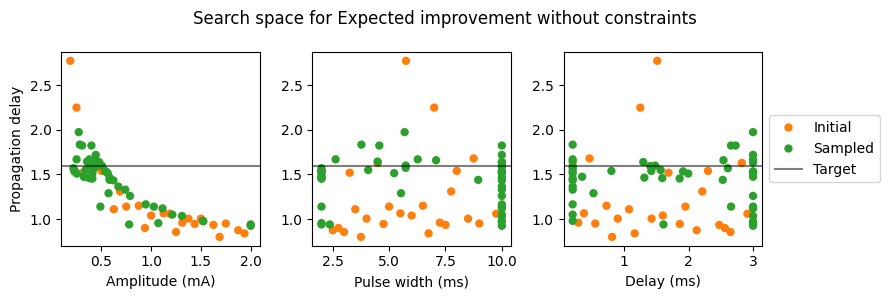

In [38]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))
colors = [
    'C1' if t == 'Initial' else 'C2'
    for t in df_min_target['sample_type']
]

for e, col in enumerate(col_names):
    ax[e].scatter(df_min_target[col], df_min_target['delay'], c=colors, edgecolors='none')
    ax[e].axhline(target_delay, color='k', alpha=0.5, label='Target {target_delay:.2f}')
    ax[e].set_xlabel(col)

# Legend: no white line, placed outside
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', label='Initial', 
           markerfacecolor='C1', markeredgecolor='none', markersize=6),
    Line2D([0], [0], marker='o', linestyle='None', label='Sampled', 
           markerfacecolor='C2', markeredgecolor='none', markersize=6),
    Line2D([0], [0], color='k', alpha=0.5, label='Target')

]

# Place outside the last subplot
ax[-1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

ax[0].set_ylabel("Propagation delay")
fig.suptitle("Search space for Expected improvement without constraints")
fig.tight_layout()
#fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust space to fit legend
plt.show()

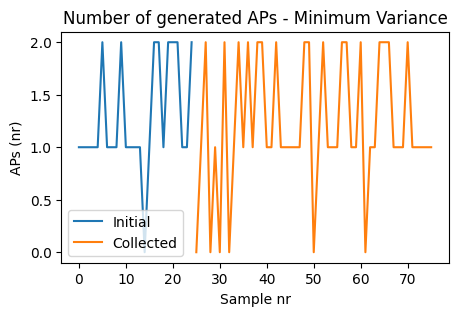

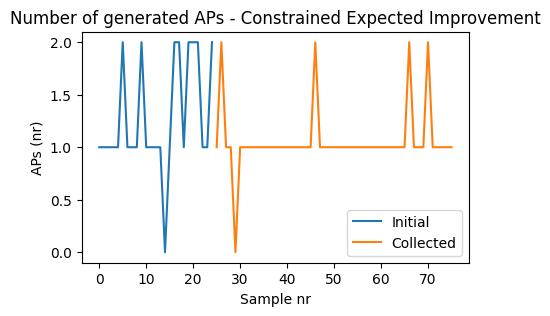

In [39]:
fig, ax = plt.subplots(figsize=(5,3))
sub_df_0 = df_min_variance.loc[df_min_variance['sample_type']=='Initial']
sub_df_1 = df_min_variance.loc[~(df_min_variance['sample_type']=='Initial')]
ax.plot(np.arange(len(sub_df_0)), sub_df_0['num_aps'], label='Initial')
ax.plot(np.arange(len(sub_df_0), len(df_min_variance)), sub_df_1['num_aps'], label='Collected')
ax.set_title("Number of generated APs - Minimum Variance")
ax.set_xlabel("Sample nr")
ax.set_ylabel("APs (nr)")
ax.legend()


fig, ax = plt.subplots(figsize=(5,3))
sub_df_0 = df_with_constraints.loc[df_with_constraints['sample_type']=='Initial']
sub_df_1 = df_with_constraints.loc[~(df_with_constraints['sample_type']=='Initial')]
ax.plot(np.arange(len(sub_df_0)), sub_df_0['num_aps'], label='Initial')
ax.plot(np.arange(len(sub_df_0), len(df_with_constraints)), sub_df_1['num_aps'], label='Collected')
ax.set_title("Number of generated APs - Constrained Expected Improvement")
ax.set_xlabel("Sample nr")
ax.set_ylabel("APs (nr)")
ax.legend()


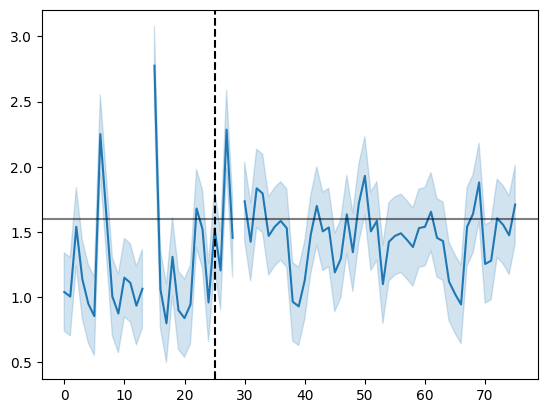

In [40]:
#df_with_constraints['delay'].plot()
plt.plot(df_with_constraints['delay'], color='C0')
plt.axhline(target_delay, color='k', alpha=0.5, label='Target {target_delay:.2f}')
plt.fill_between(np.arange(len(df_with_constraints)), 
                 df_with_constraints['delay']- NOISE_LEVEL*3,
                    df_with_constraints['delay']+ NOISE_LEVEL*3, color='C0', 
                    alpha=0.2, label='Noise range')
plt.axvline(init_samples, color = 'k', ls='--', label='Start optimization')
plt.show()

Text(0.5, 1.0, 'Loss over samples - Constrained Expected Improvement')

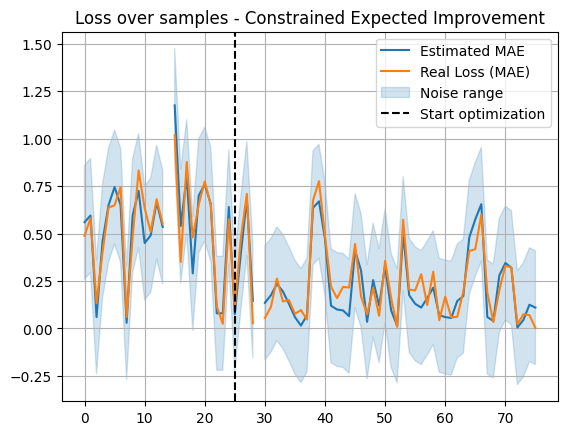

In [41]:
df_with_constraints['Loss (MAE)'].plot(label='Estimated MAE', color='C0')
df_with_constraints['Real Loss (MAE)'].plot(label='Real Loss (MAE)', color='C1')
plt.fill_between(np.arange(len(df_with_constraints)),
                 df_with_constraints['Loss (MAE)']- NOISE_LEVEL*3,
                 np.clip(df_with_constraints['Loss (MAE)']+ NOISE_LEVEL*3, 0, None), color='C0',
                 alpha=0.2, label='Noise range')

plt.axvline(init_samples, color = 'k', ls='--', label='Start optimization')
plt.legend()
plt.grid()
plt.title("Loss over samples - Constrained Expected Improvement")

## Using the learned model (with constraints) to find an optimal solution usign gradient minimzers

In [42]:
# 1. Get the final, trained models from the optimizer
objective_model = ask_tell.models['OBJECTIVE']
constraint_model = ask_tell.models['CONSTRAINT']

# 2. Define a function that returns the model's predicted objective
#    We will use scipy.optimize to minimize this function.
def prediction_objective_fn(x):
    query_point = tf.cast(np.atleast_2d(x), dtype=tf.float64)
    
    # Get predictions from both models
    # We want the *mean* of the prediction
    predicted_objective_mean, _ = objective_model.predict(query_point)
    predicted_constraint_mean, _ = constraint_model.predict(query_point)
    
    # Penalize the objective if the constraint is not likely to be met.
    # If predicted_constraint_mean is close to 1, the penalty is ~0.
    # If it's close to 0, the penalty is large.
    # This turns it into a single objective minimization problem.
    constraint_penalty = 100 * (1.0 - predicted_constraint_mean[0, 0])**2
    
    # Return the value to be minimized
    return predicted_objective_mean[0, 0] + constraint_penalty

# Alternative to optimize toward LCB
def lcb_objective_fn(x, kappa=1.96): # kappa=1.96 corresponds to the 95% confidence interval
    # Reshape for the model and cast to the correct dtype
    query_point = tf.cast(np.atleast_2d(x), dtype=tf.float64)
    
    # Get predictions (mean and variance) from the objective model
    predicted_objective_mean, predicted_objective_var = objective_model.predict(query_point)
    predicted_objective_std = tf.sqrt(predicted_objective_var) # Standard deviation = sqrt(variance)

    # Get prediction from the constraint model
    predicted_constraint_mean, _ = constraint_model.predict(query_point)
    
    # Calculate the Lower Confidence Bound (LCB)
    lcb_value = predicted_objective_mean[0, 0] - kappa * predicted_objective_std[0, 0]
    
    # Add the same constraint penalty as before
    # We want points that are confidently good AND satisfy the constraint
    constraint_penalty = 100 * (1.0 - predicted_constraint_mean[0, 0])**2
    
    # Return the value to be minimized
    return lcb_value + constraint_penalty
# 3. Run the optimization
bounds = [(-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)]
best_params = df_with_constraints.loc[df_with_constraints['Loss (MAE)'].idxmin(), col_names].values

# Use the best observed point as a smart starting guess
best_observed_minmax = scaler.transform(best_params.reshape(1, -1))
initial_guess = best_observed_minmax.flatten()

# Run scipy's minimizer
result = minimize(
    prediction_objective_fn,
    x0=initial_guess,
    bounds=bounds,
    method='L-BFGS-B'
)

# 4. Extract and inverse-transform the predicted best parameters
predicted_best_params_minmax = result.x
predicted_best_params = scaler.inverse_transform(predicted_best_params_minmax.reshape(1, -1)).flatten()


In [43]:
pd.DataFrame(scaler.transform(df_with_constraints[col_names])).describe()

,0,1,2
count,76.000000,76.000000,76.000000
mean,-0.299839,0.012583,-0.062537
std,0.482460,0.661196,0.737904
min,-0.931323,-1.000000,-1.000000
25%,-0.625449,-0.565198,-0.814700
50%,-0.504703,-0.093750,-0.072625
75%,-0.046875,0.621532,0.628013
max,0.937500,1.000000,1.000000


In [44]:
best_params, initial_guess

(array([0.43449090539659574, 6.5250499100147, 1.3711892309687634],
       dtype=object),
 array([-0.5655090946034043, 0.13126247750367503, -0.1634362635937403],
       dtype=object))

In [45]:
print("\n--- Model-Predicted Optimal Result ---")
print(f"Scipy optimization successful: {result.success}")
print(f"Predicted minimum MAE: {result.fun:.4f}")
print("\nPredicted Best Parameters:")
print(f"  - Stim Amp:  {predicted_best_params[0]:.4f}")
print(f"  - Stim Freq: {predicted_best_params[1]:.4f}")
print(f"  - Stim PW:   {predicted_best_params[2]:.4f}")


--- Model-Predicted Optimal Result ---
Scipy optimization successful: True
Predicted minimum MAE: 0.5398

Predicted Best Parameters:
  - Stim Amp:  0.3612
  - Stim Freq: 10.0000
  - Stim PW:   2.0037


In [46]:
print(initial_guess)
print(best_params)

[-0.5655090946034043 0.13126247750367503 -0.1634362635937403]
[0.43449090539659574 6.5250499100147 1.3711892309687634]


Config: Amp. 0.43 mA Freq. 6.53 KHz,  PW 1.37 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 255.62it/s]
/home/idlab398/online-neuro/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


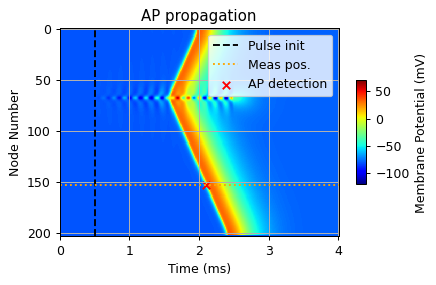

{'delay': 1.6049999999999662, 'num_aps': 1, 'delay_noised': 1.6394021572920319, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 316, 'component_end_time': 523, 'upward_line_coords': ((316, 67), (436, 1)), 'downward_line_coords': ((316, 67), (523, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 6, 'component_start_time': 362, 'component_end_time': 375, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 397, 'component_end_time': 403, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 429, 'component_end_time': 433, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

In [47]:
sim_results_initial_guess = sinusoid_delay_objective(mrg,
                                        stim_amp = [best_params[0]],
                                        stim_freq = [best_params[1]],
                                        stim_pw = [best_params[2]],
                                        stim_delay = stim_delays,
                                        meas_position = meas_position, 
                                        e_pos = stim_distance,
                                        abs_diff = False,
                                        sim_time = 4,
                                        plot_results = True,
                                        noise_level=NOISE_LEVEL)
            

Config: Amp. 0.36 mA Freq. 10.00 KHz,  PW 2.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 208.05it/s]


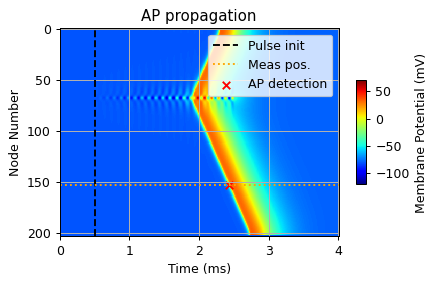

{'delay': 1.9299999999999593, 'num_aps': 1, 'delay_noised': 1.862313486974249, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 383, 'component_end_time': 588, 'upward_line_coords': ((383, 65), (501, 1)), 'downward_line_coords': ((383, 70), (588, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 5, 'component_start_time': 432, 'component_end_time': 440, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 5, 'component_start_time': 454, 'component_end_time': 458, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 5, 'component_start_time': 475, 'component_end_time': 477, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, 

In [48]:
sim_results_optimized = sinusoid_delay_objective(mrg,
                                        stim_amp = [predicted_best_params[0]],
                                        stim_freq = [predicted_best_params[1]],
                                        stim_pw = [predicted_best_params[2]],
                                        stim_delay = stim_delays,
                                        meas_position = meas_position, 
                                        e_pos = stim_distance,
                                        abs_diff = False,
                                        sim_time = 4,
                                        plot_results = True,
                                        noise_level=NOISE_LEVEL)
            

In [49]:
print(sim_results_initial_guess)
print(sim_results_optimized)
print(target_delay)

[{'delay': 1.6049999999999662, 'num_aps': 1, 'delay_noised': 1.6394021572920319, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 316, 'component_end_time': 523, 'upward_line_coords': ((316, 67), (436, 1)), 'downward_line_coords': ((316, 67), (523, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 6, 'component_start_time': 362, 'component_end_time': 375, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 397, 'component_end_time': 403, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 429, 'component_end_time': 433, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}

In [51]:
online_models['OBJECTIVE']._model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,(),float64,0.8359686207630692
GPR.kernel.variance,Parameter,Softplus,LogNormal,True,(),float64,0.515664950182186
GPR.kernel.lengthscales,Parameter,Softplus,LogNormal,True,"(3,)",float64,[0.07548721 1.19248 4.7182 ]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.1046936194183446e-07
GPR.data[0],ResourceVariable,,,False,"(None, 3)",float64,"[[0., 0., 0...."
GPR.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[4.87466891e-01...


In [52]:
online_models['CONSTRAINT']._model

name,class,transform,prior,trainable,shape,dtype,value
VGP.mean_function.c,Parameter,Identity,,True,(),float64,0.759837138907367
VGP.kernel.variance,Parameter,Softplus,LogNormal,True,(),float64,0.8157677972549932
VGP.kernel.lengthscales,Parameter,Softplus,LogNormal,True,"(3,)",float64,[0.34514108 0.53611971 0.95801604]
VGP.data[0],ResourceVariable,,,False,"(None, 3)",float64,"[[0., 0., 0...."
VGP.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[1....
VGP.num_data,Parameter,Identity,,False,(),int32,76
VGP.q_mu,Parameter,Identity,,True,"(None, 1)",float64,[[4.18298466e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, None, None)",float64,"[[[7.82900064e-01, 0.00000000e+00, 0.00000000e+00..."
